## Model Assumptions
* Once Recovered can't be infected again. Recovered and Death cases are simply removed from population.
* An airplane carries 115 passengers on average
* Number of people getting into a country is estimated as 

$$incomingPeople=incomingRoutes \cdot log_{10}~countryPopulation $$

* Number of people getting out of a country is estimated as 

$$outgoingPeople=outgoingRoutes \cdot log_{10}~countryPopulation $$

     This will be fractured for each compartment (S, I, R)


#### Useful notes
* beta and gamma can be selected from rates determined from prior outbreaks, but they often vary for different outbreaks of the same disease
* __To estimate beta and gamma from data__: if beta=0.29/day, the time it takes to double the number of infected people is about 1/0.29 = 3.4 days, hence, beta=1/days it takes to double infections. Similarly, gamma=0.15 implies that is takes 1/0.15=6.7 days to recover/die, hence, gamma=1/days it takes to recover/die.


In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import json
import networkx as nx
from datetime import datetime as dt, date, timedelta
from math import log
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep

%matplotlib inline

In [2]:
# Load Graph
g_data = json.load(open("data/graph_to_load_in_nx.json", "r"))
g = nx.DiGraph()
g.add_weighted_edges_from(g_data)
countries = list(g.nodes)

In [3]:
# Load country coordinates and attach to nodes
countries_coords = pd.read_csv("data/country_centroids_az8.csv")
countries_coords = countries_coords[['name', 'Longitude', 'Latitude']]
countries_coords.replace(["Macao", "Korea"], ["Macau", "South Korea"], inplace=True)
countries_coords.index = countries_coords.name
countries_coords.loc['France', 'Longitude'] = 2.2137
countries_coords.loc['France', 'Latitude'] = 46.2276
countries_coords = countries_coords[countries_coords.name.isin(countries)][['Longitude', 'Latitude']]
coords_dict = countries_coords.to_dict(orient='index')
nx.set_node_attributes(g, coords_dict)

In [4]:
# Load Population data and attach to nodes
countries_population_data = pd.read_csv("data/countries_population_data.csv", index_col=0)
for c in countries:
    pop = countries_population_data[countries_population_data['Country'] == c]['Pop 2018'].values[0]
    nx.set_node_attributes(g, {c: {'Population': pop}})

In [5]:
# Load and clean COVID-19 data
confirmed = pd.read_csv("data/time_series_covid19_confirmed_global.csv")
confirmed.loc[61, 'Country/Region'] = "Hong Kong"  #Hong Kong as its own country
confirmed.loc[69, 'Country/Region'] = "Macau"  #Hong Kong as its own country
confirmed.replace(["Taiwan*", "Korea, South", "US"], ["Taiwan", "South Korea", "United States"], inplace=True)
confirmed = confirmed.groupby('Country/Region').sum()  #Group regions by country
confirmed = confirmed[confirmed.index.isin(countries)]
confirmed.drop(["Lat", "Long"], axis=1, inplace=True)
assert len(set(countries).difference(confirmed.index.values.tolist())) == 0

recovered = pd.read_csv("data/time_series_covid19_recovered_global.csv")
recovered.loc[52, 'Country/Region'] = "Hong Kong"  #Hong Kong as its own country
recovered.loc[60, 'Country/Region'] = "Macau"  #Hong Kong as its own country
recovered.replace(["Taiwan*", "Korea, South", "US"], ["Taiwan", "South Korea", "United States"], inplace=True)
recovered = recovered.groupby('Country/Region').sum()  #Group regions by country
recovered = recovered[recovered.index.isin(countries)]
recovered.drop(["Lat", "Long"], axis=1, inplace=True)
assert len(set(countries).difference(recovered.index.values.tolist())) == 0

deaths = pd.read_csv("data/time_series_covid19_deaths_global.csv")
deaths.loc[61, 'Country/Region'] = "Hong Kong"  #Hong Kong as its own country
deaths.loc[69, 'Country/Region'] = "Macau"  #Hong Kong as its own country
deaths.replace(["Taiwan*", "Korea, South", "US"], ["Taiwan", "South Korea", "United States"], inplace=True)
deaths = deaths.groupby('Country/Region').sum()  #Group regions by country
deaths = deaths[deaths.index.isin(countries)]
deaths.drop(["Lat", "Long"], axis=1, inplace=True)
assert len(set(countries).difference(deaths.index.values.tolist())) == 0

np.testing.assert_array_equal(confirmed.index.values, recovered.index.values, deaths.index.values)


In [6]:
# Define function to estimate Beta and Gamma given COVID-19 data
def getEstimatedBetaGamma(country, initial_pop, confirmed, recovered, deaths, T, verbose=True):
       
        first_confirmed_case = confirmed[confirmed.index == country].iloc[0].ne(0).idxmax()
        country_confirmed = confirmed[confirmed.index == country].loc[country, first_confirmed_case:].values
        I_0 = country_confirmed[0]

        country_recovered = recovered[recovered.index == country].loc[country, first_confirmed_case:].values
        R_0 = country_recovered[0]

        country_deaths = deaths[deaths.index == country].loc[country, first_confirmed_case:].values
        
        if verbose:
            print("{}'s first confirmed cases date: {} with {} infected and {} recovered.".format(
                country, first_confirmed_case, I_0, R_0
            ))

        S = [ initial_pop ]
        I = [ I_0 ]
        R = [ R_0 ]
        for t in range(1, len(country_confirmed)-1):
            
            S_t = S[t-1] - (country_confirmed[t] + country_recovered[t] + country_deaths[t])
            S.append(S_t)
            I_t = country_confirmed[t]
            I.append(I_t)
            R_t = country_recovered[t] + country_deaths[t]
            R.append(R_t)


        confirmed_doubled_intervals = []
        for i0 in range(len(I)):
            for i1 in range(len(I)):
                if I[i1] >= I[i0]*2:
                    confirmed_doubled_intervals.append(i1 - i0)
                    break

        country_betas = np.array([1/n if n>0 else 0 for n in confirmed_doubled_intervals])
        #print(country_betas)
        if verbose:
            print("{}'s average beta: {}".format(country, country_betas.mean().round(5)))

        confirmed_to_recovered_or_died_intervals = []
        for i in range(len(country_confirmed)):
            infected = country_confirmed[i]
            for j in range(len(country_confirmed)):
                recovered = country_recovered[j]
                deaths = country_deaths[j]
                if (recovered+deaths) >= infected:
                    confirmed_to_recovered_or_died_intervals.append(j-i)
                    break

        country_gammas = np.array([1/n if n>0 else 0 for n in confirmed_to_recovered_or_died_intervals])
        if verbose:
            print("{}'s average gamma: {}".format(country, country_gammas.mean().round(5)))

        return country_betas.mean(), country_gammas.mean()

In [7]:
# Estimate beta and gamma for each country and attach to node

T = 350  # Simulation number of days 

affected_countries_population = 0

country_populations = nx.get_node_attributes(g, "Population")
for c in countries:
    affected_countries_population += country_populations[c]
    beta, gamma = getEstimatedBetaGamma(c, country_populations[c], confirmed, recovered, deaths, T, verbose=False)
    nx.set_node_attributes(g, {c: {"Beta": beta, 'Gamma': gamma}})

## Simulation with no restrictions

In [8]:
# Simulation
country_betas = nx.get_node_attributes(g, "Beta")
country_gammas = nx.get_node_attributes(g, "Gamma")

# Precompute outbound routes for each country
out_routes = {}
for country in countries:
    outgoing_routes = sum([g.get_edge_data(country, i)["weight"] for i in g.neighbors(country)])
    out_routes[country] = outgoing_routes

S_lists = {}
I_lists = {}
R_lists = {}

# Initialise lists values
for c in countries:
    S_lists[c] = [ country_populations[c] ]
    I_lists[c] = [ confirmed.loc[c, confirmed.columns[0]] ]
    R_lists[c] = [ deaths.loc[c, deaths.columns[0]] ]
    
# Carry out simulation
for t in range(1, T):
    for c in countries:
        # Get people coming into the country for each compartment
        S_in_t = 0
        I_in_t = 0
        R_in_t = 0
        total_in = 0
        for n in g.nodes():
            if g.get_edge_data(n, c) is not None:
                n_in_route = g.get_edge_data(n, c)['weight'] 
                n_total_pop = S_lists[n][t-1] + I_lists[n][t-1] + R_lists[n][t-1]
                n_in_population = n_in_route * np.log10(n_total_pop)
                total_in += n_in_population
                S_in_t += (S_lists[n][t-1] / n_total_pop) * n_in_population
                I_in_t += (I_lists[n][t-1] / n_total_pop) * n_in_population
                R_in_t += (R_lists[n][t-1] / n_total_pop) * n_in_population
        # Get people going out of the country for each compartment
        current_population = S_lists[c][t-1] + I_lists[c][t-1] + R_lists[c][t-1]
        out_population = out_routes[c] * np.log10(current_population)
 
        S_out_t = (S_lists[c][t-1] / current_population) * out_population
        I_out_t = (I_lists[c][t-1] / current_population) * out_population
        R_out_t = (R_lists[c][t-1] / current_population) * out_population

        S_t = S_lists[c][t-1] - ((S_lists[c][t-1] / S_lists[c][0]) * (country_betas[c]*I_lists[c][t-1]))
        S_lists[c].append(S_t - S_out_t + S_in_t)
        
        I_t = I_lists[c][t-1] + ((S_lists[c][t-1] / S_lists[c][0]) * (country_betas[c]*I_lists[c][t-1])) - (I_lists[c][t-1] * country_gammas[c])
        I_lists[c].append(I_t - I_out_t + I_in_t)
        
        R_t = R_lists[c][t-1] + (I_lists[c][t-1] * country_gammas[c])
        R_lists[c].append(R_t - R_out_t + R_in_t)
        
      

South Korea


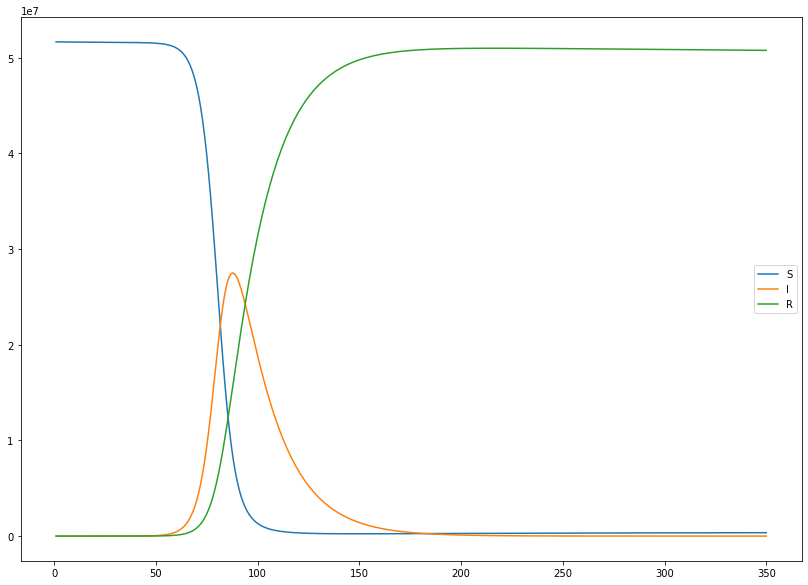

Israel


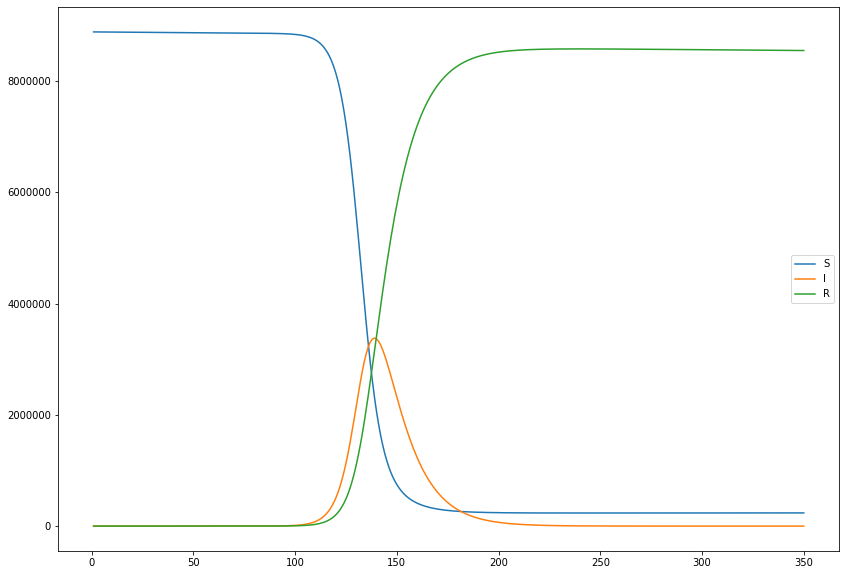

Philippines


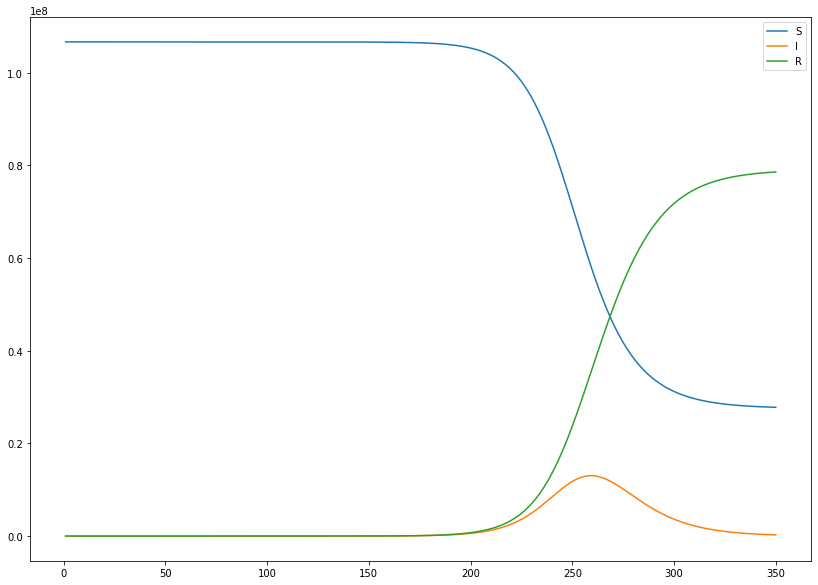

United States


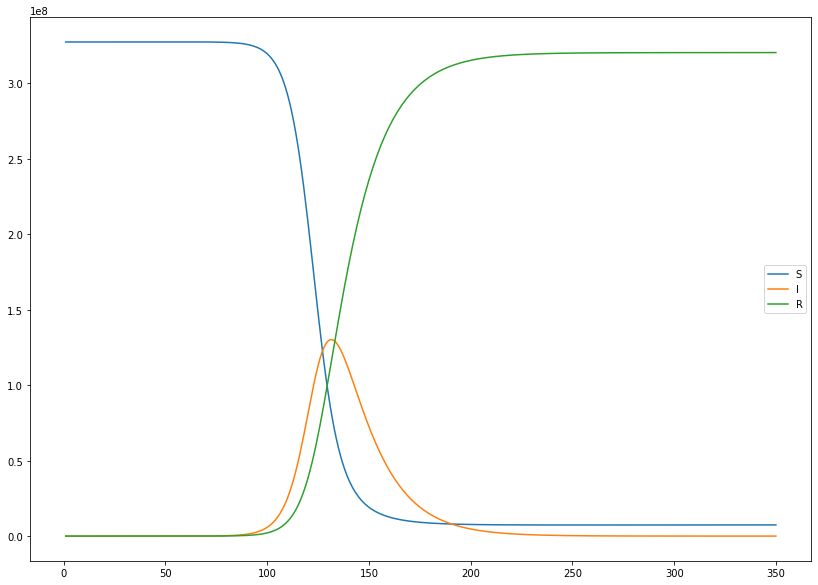

United Kingdom


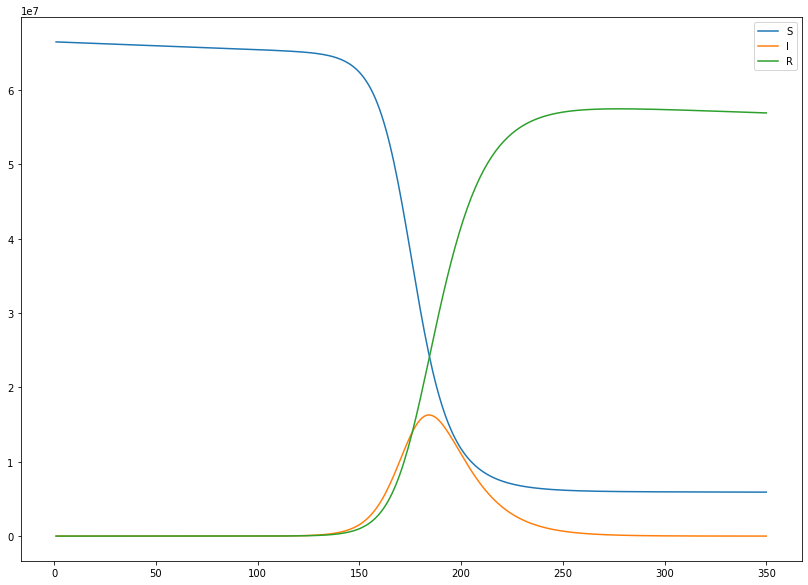

Singapore


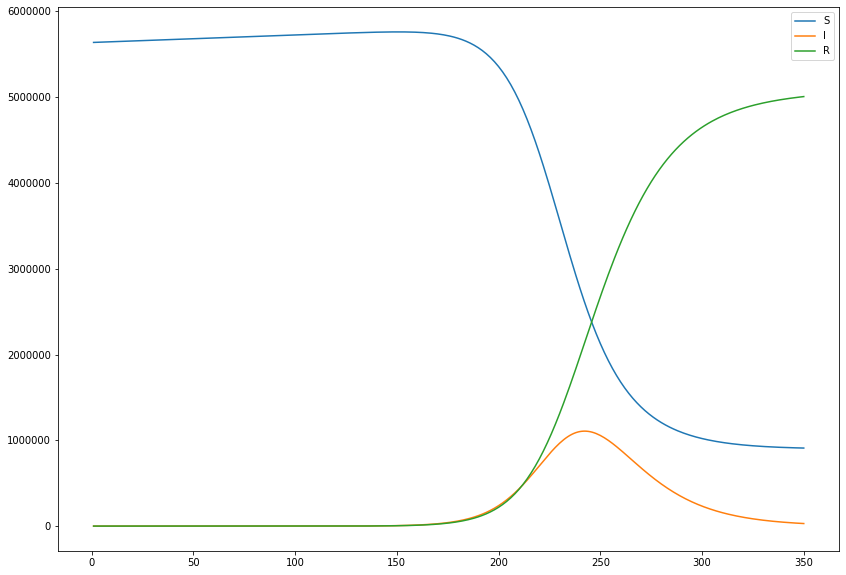

Sweden


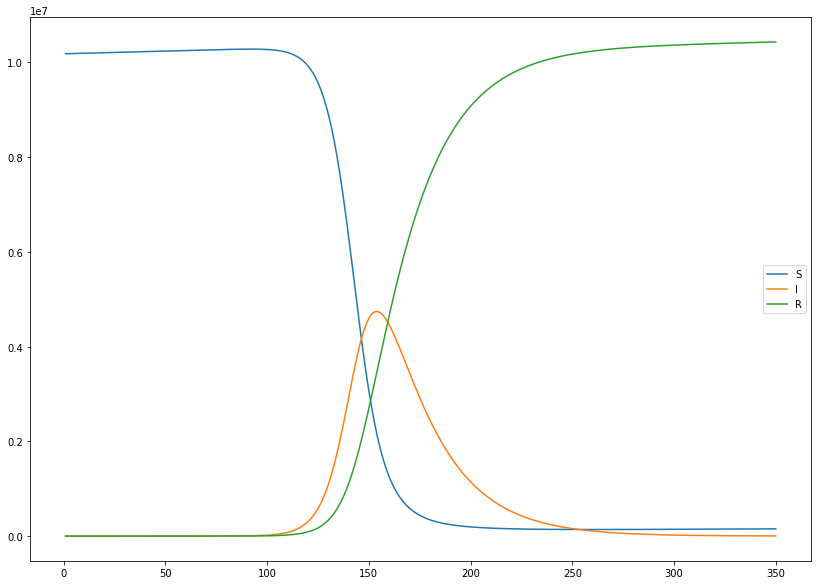

Italy


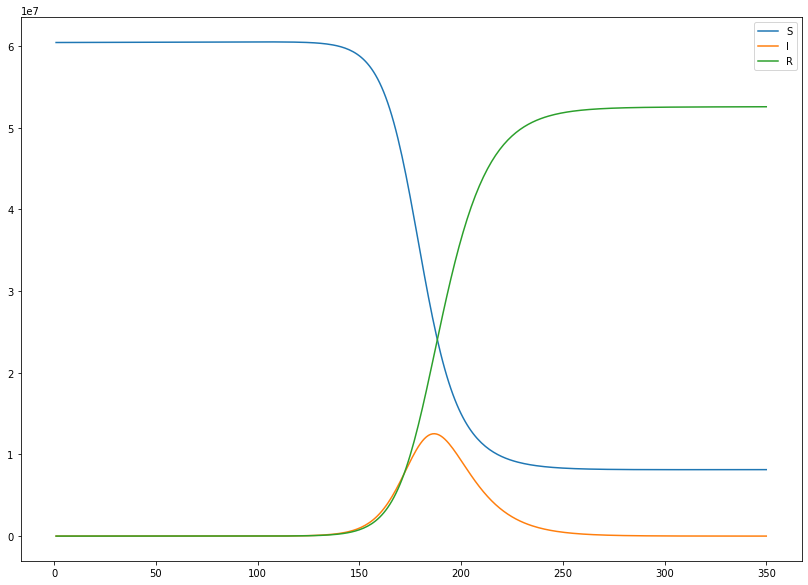

France


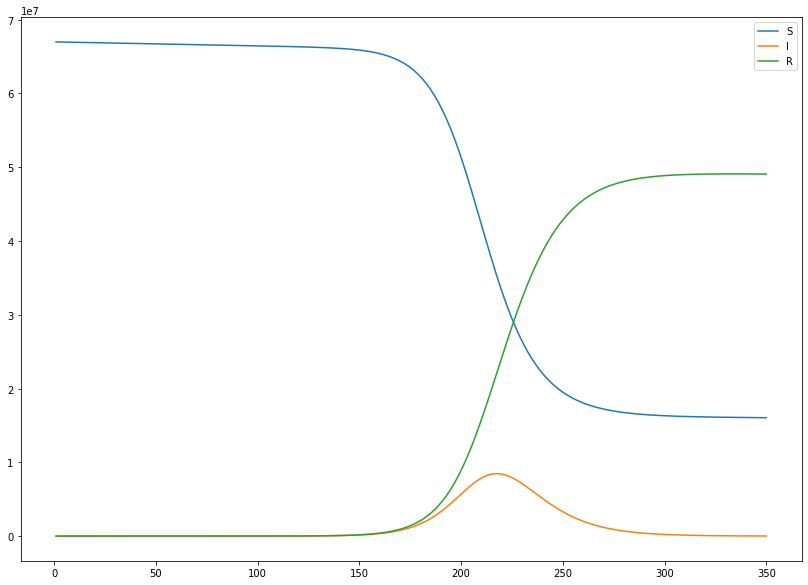

Finland


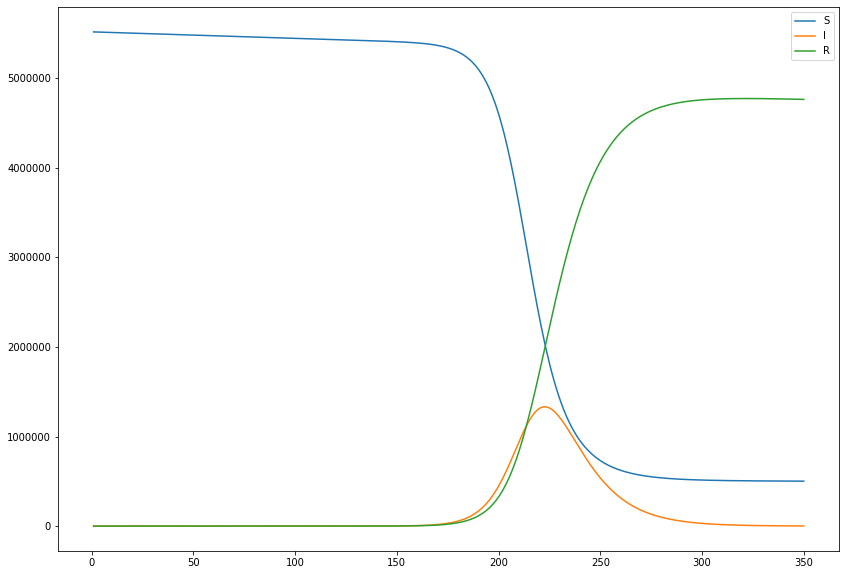

Vietnam


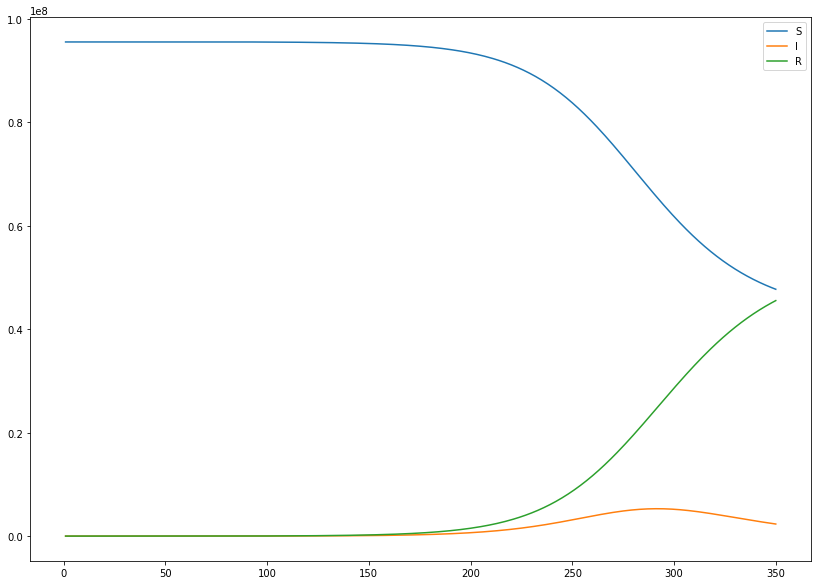

Russia


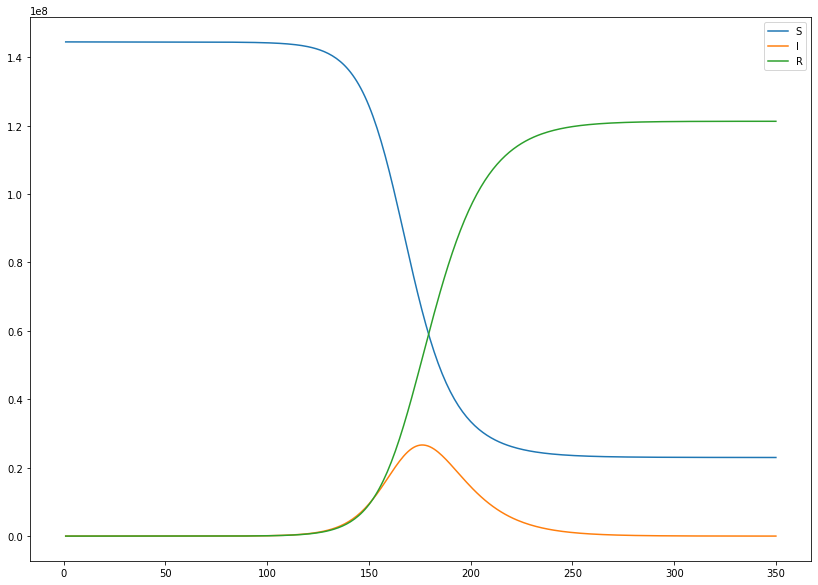

Macau


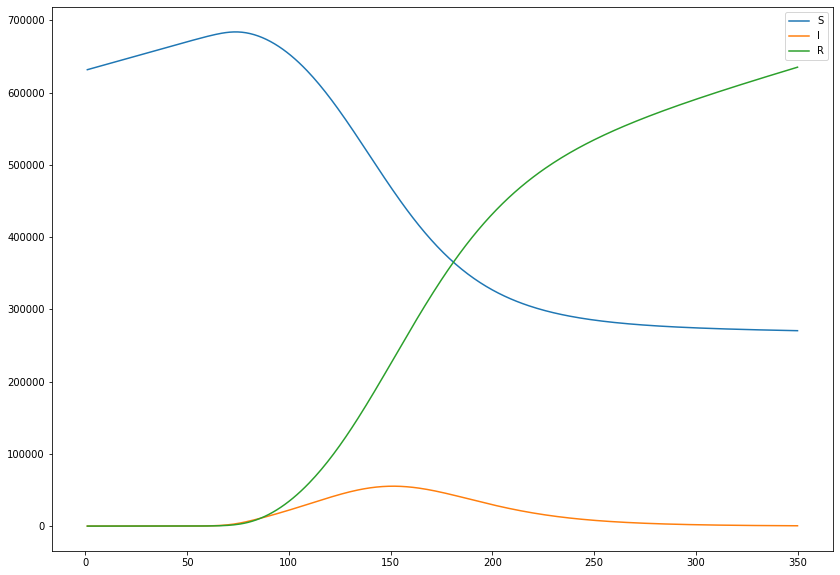

Taiwan


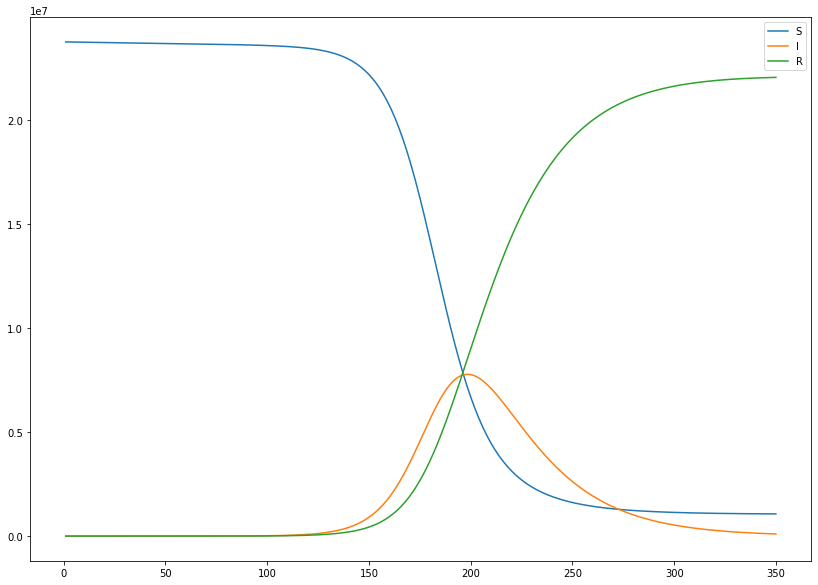

Japan


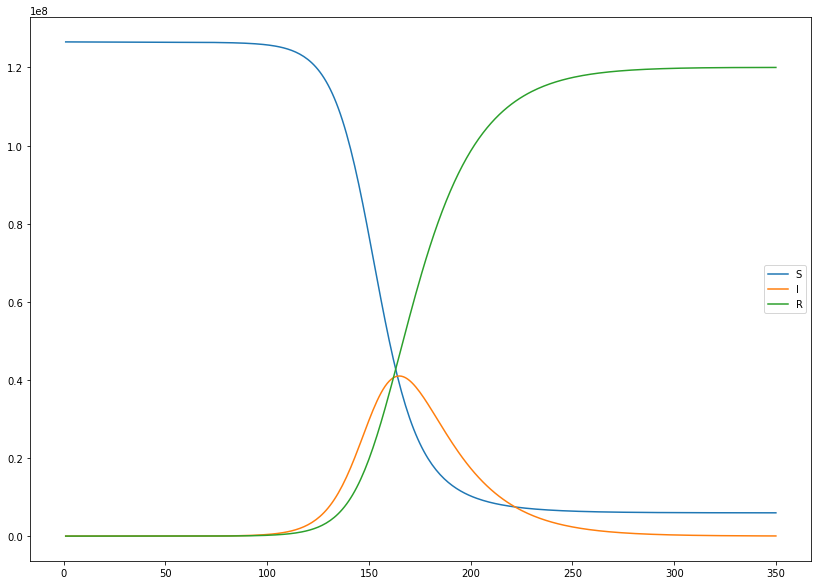

Malaysia


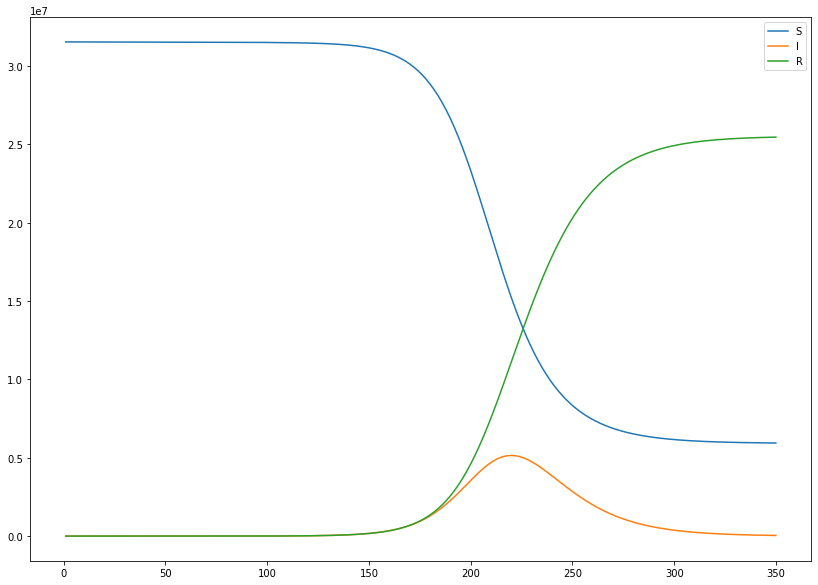

Thailand


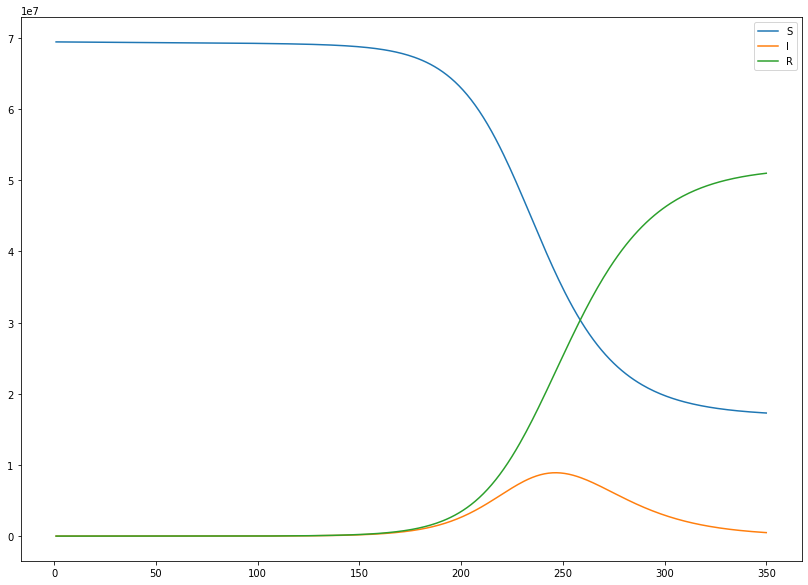

Germany


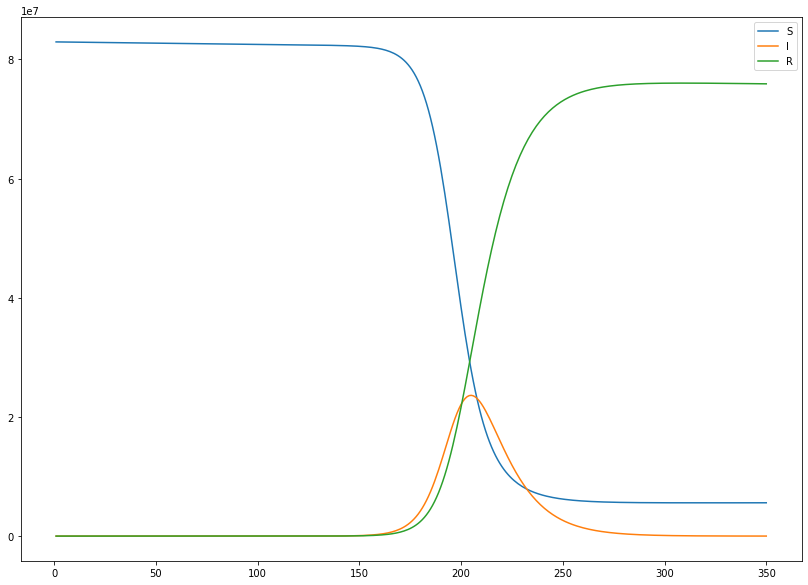

Australia


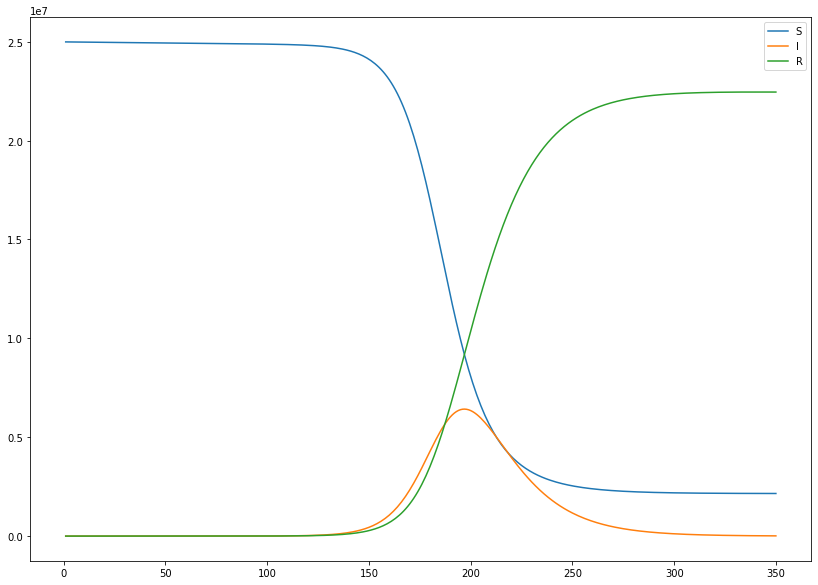

United Arab Emirates


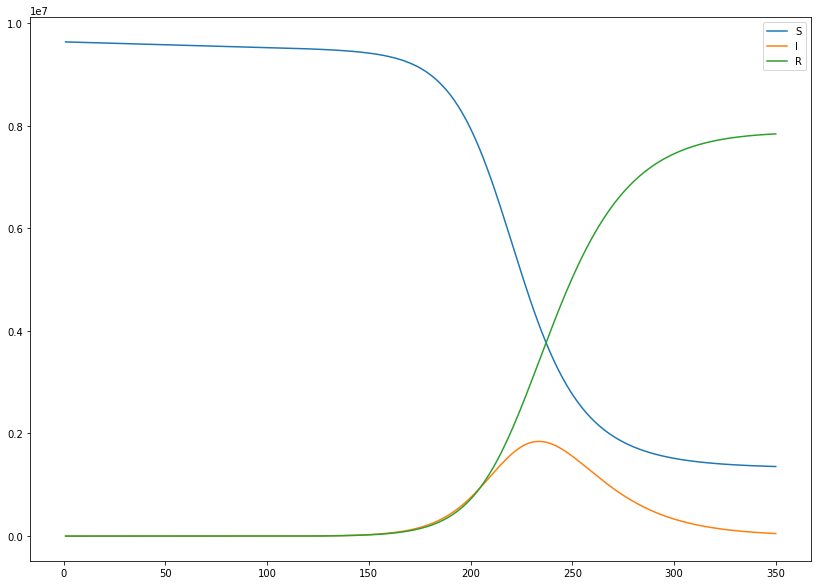

Canada


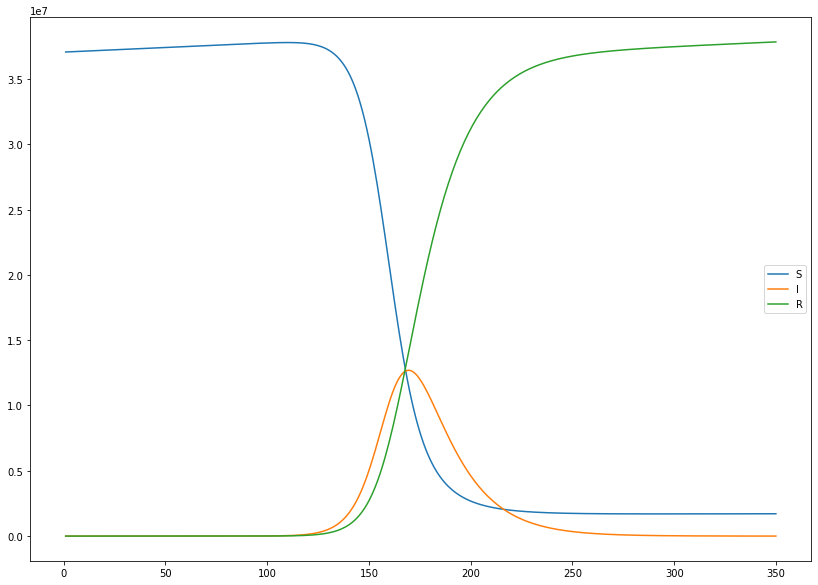

Bahrain


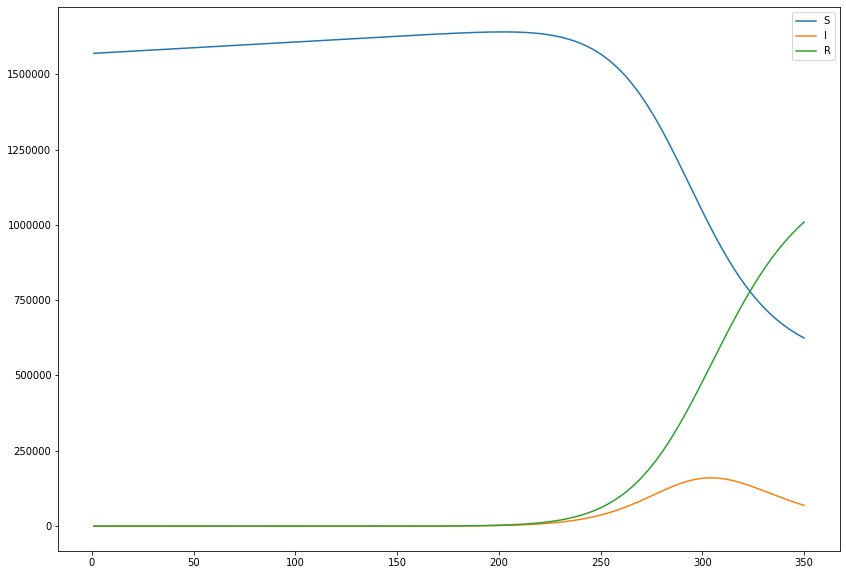

Iran


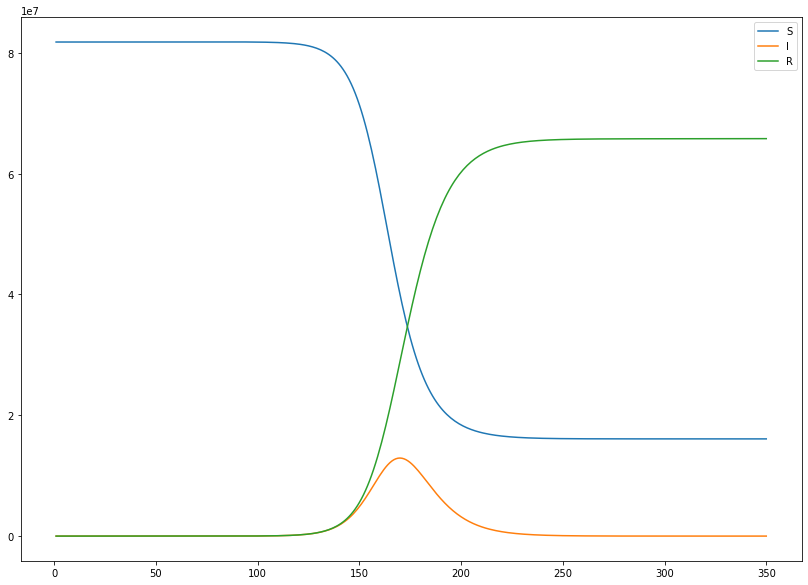

Belgium


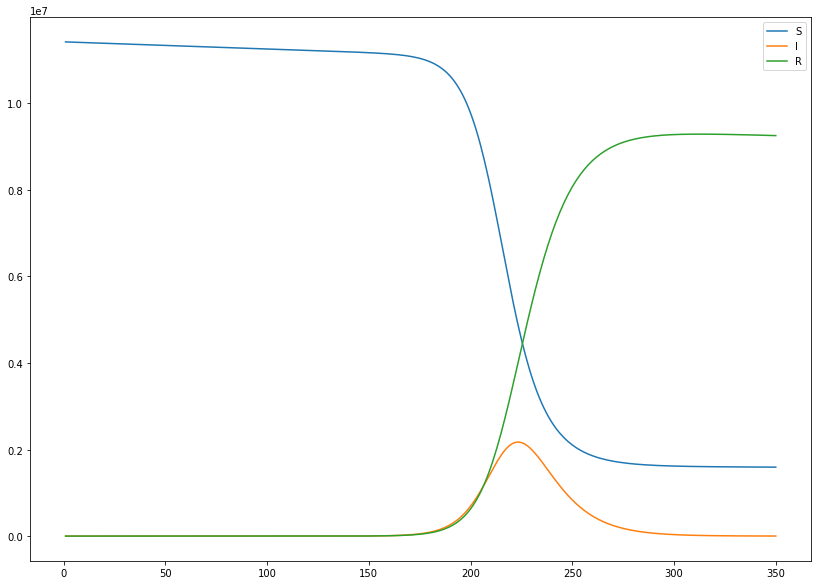

China


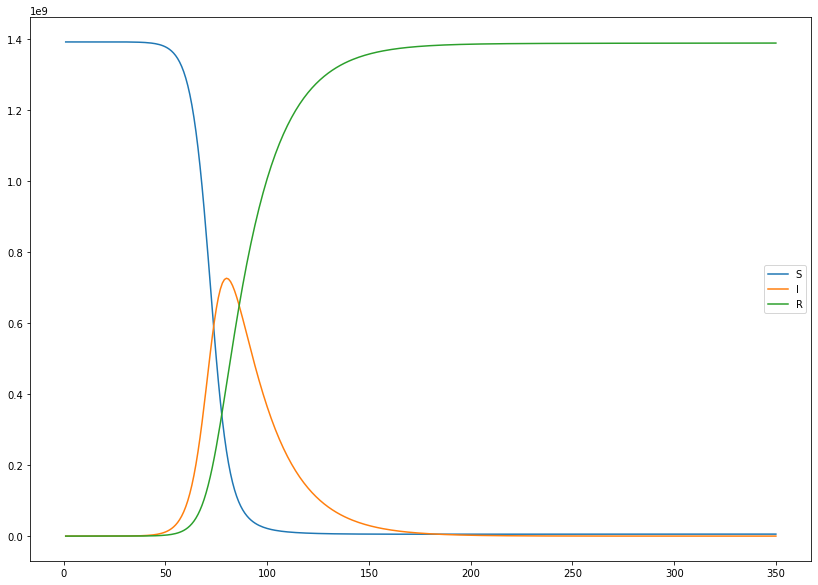

Spain


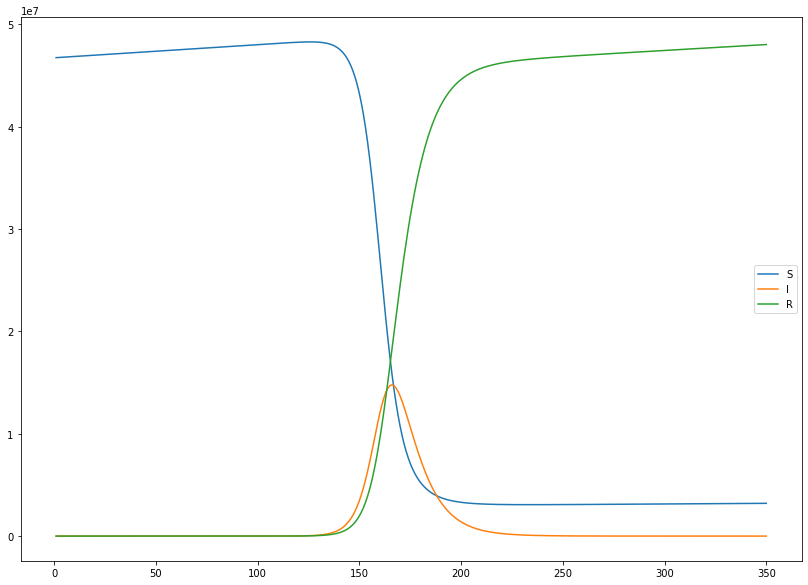

Hong Kong


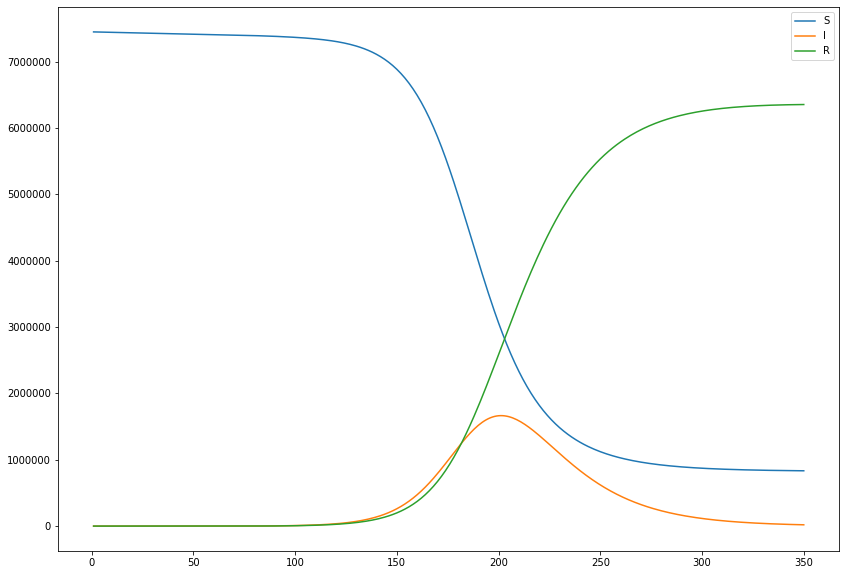

Sri Lanka


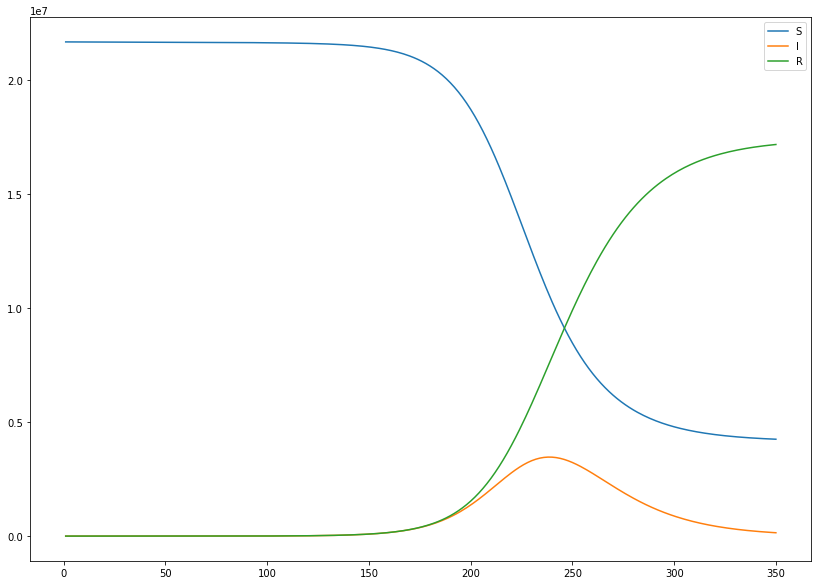

Kuwait


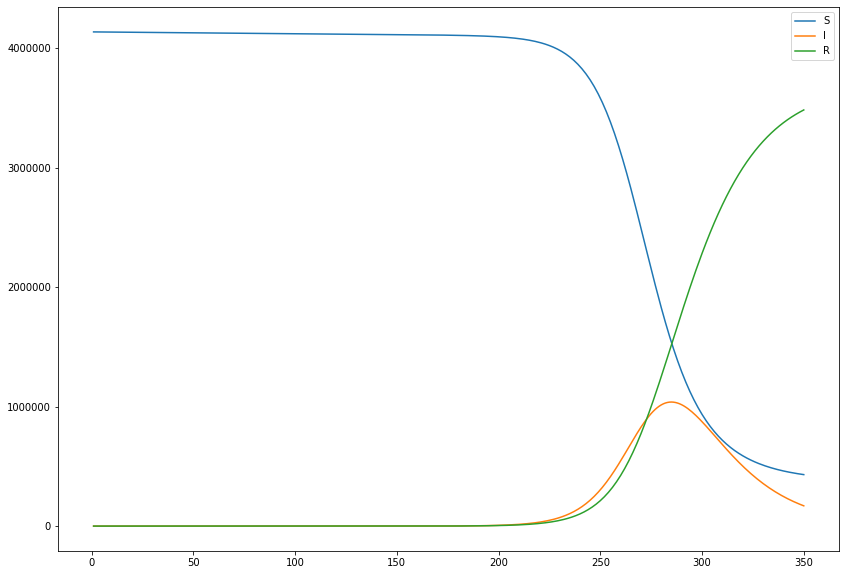

Oman


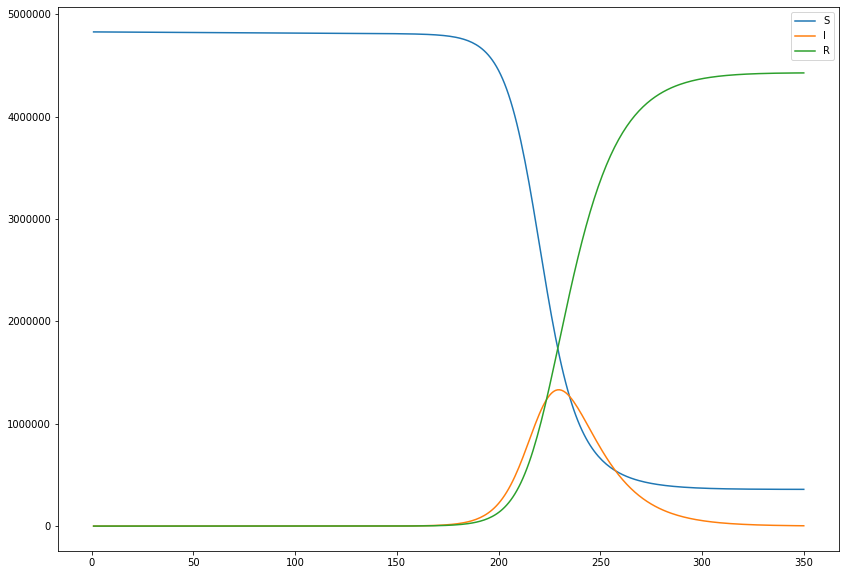

Lebanon


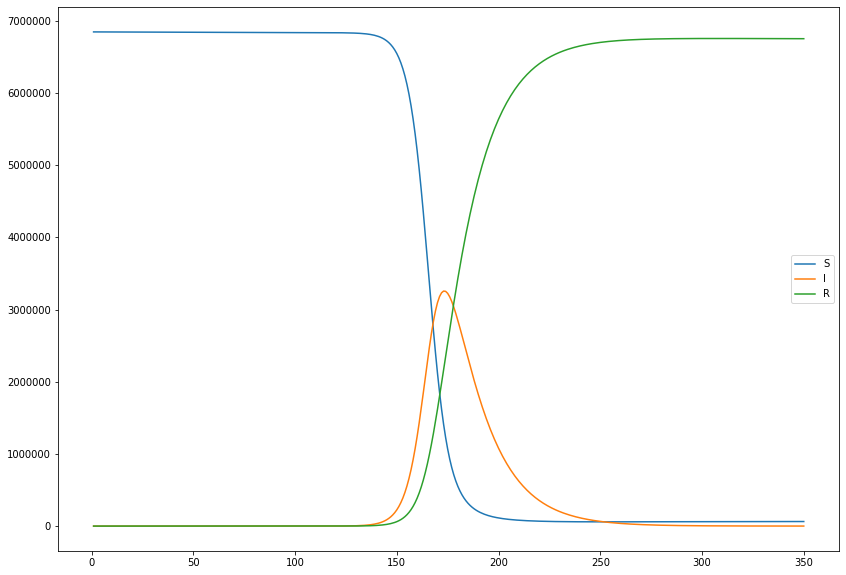

Iraq


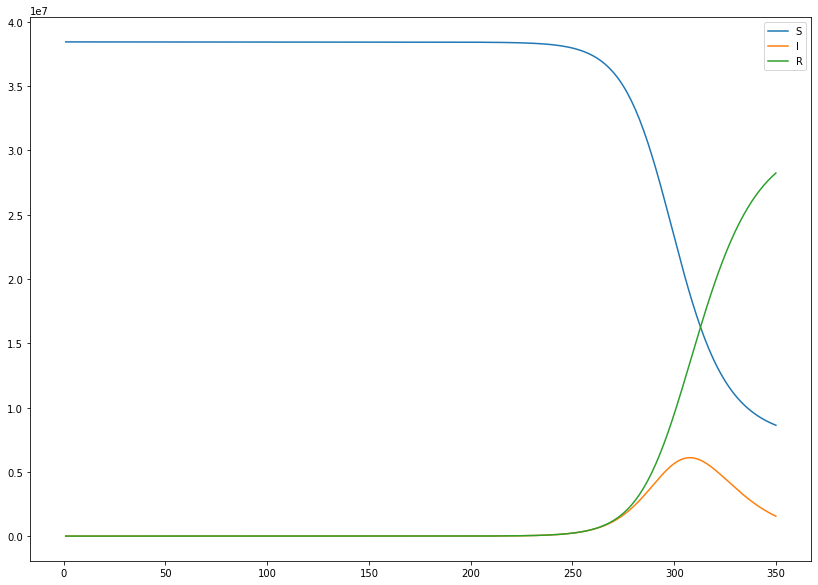

Egypt


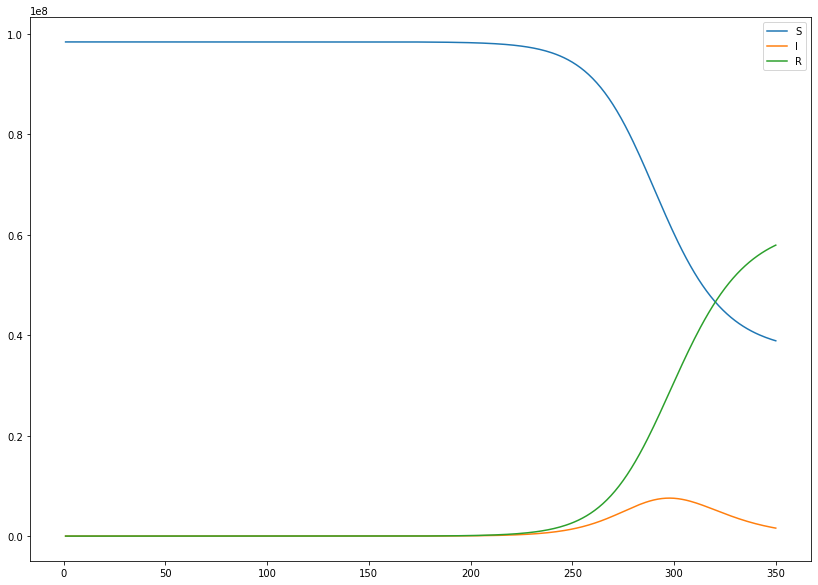

Cambodia


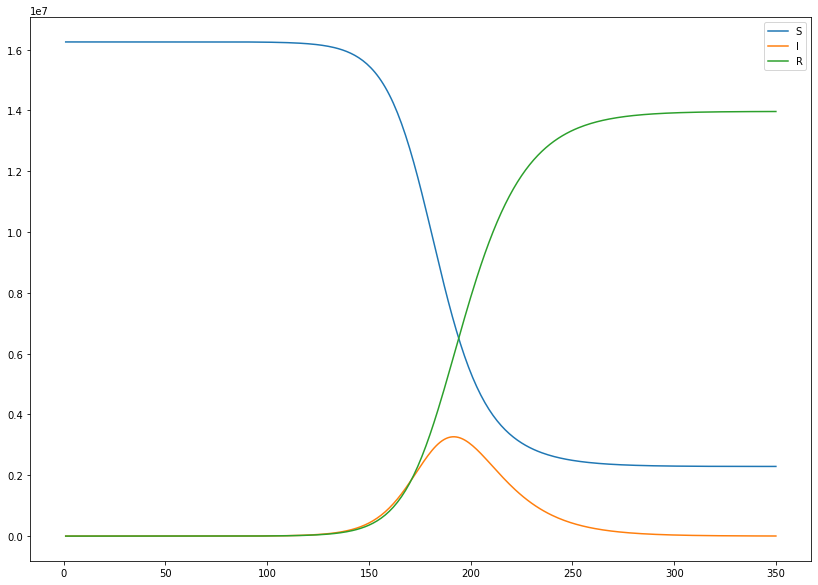

India


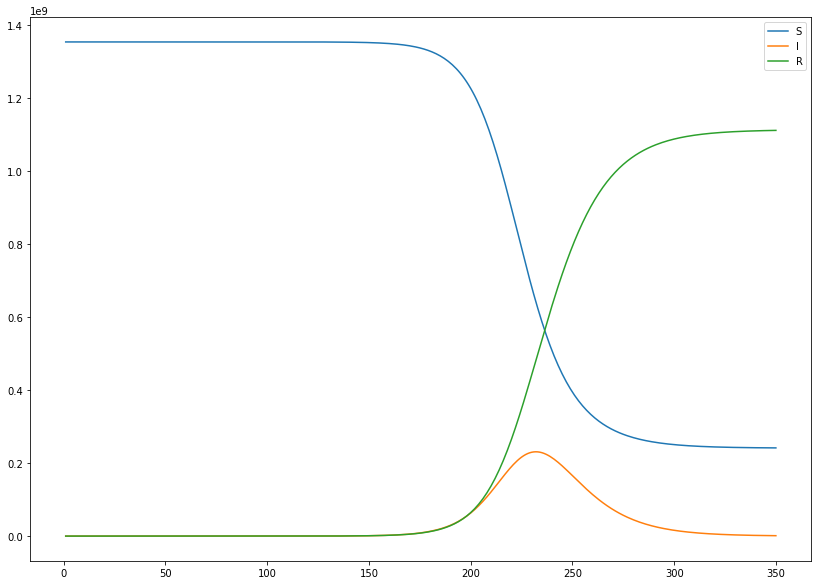

Nepal


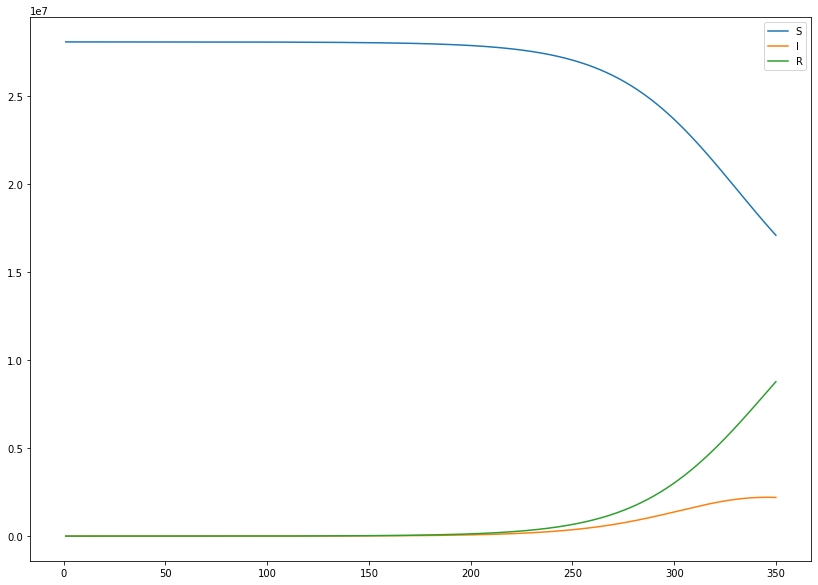

Afghanistan


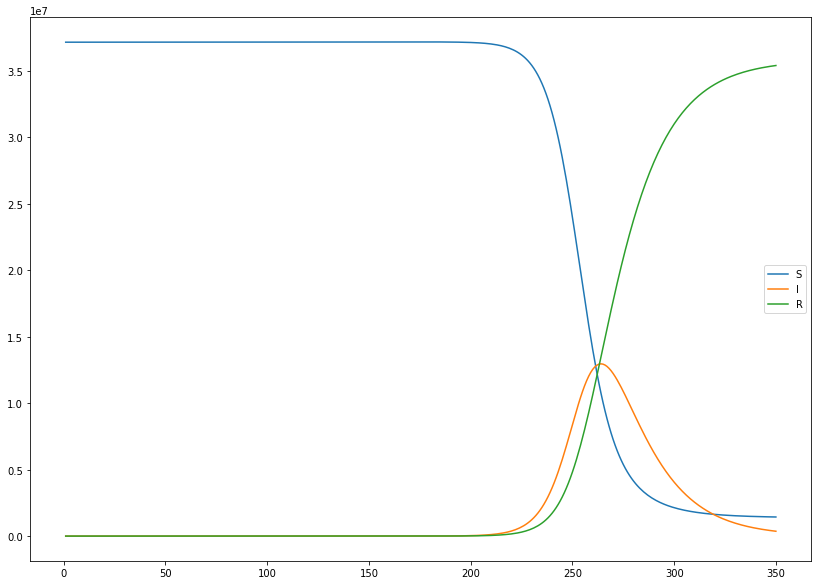

In [9]:
# Visualize simulation results
x = list(range(T))
for c in countries:
    print(c)
    plt.figure(figsize=(14,10))
    plt.plot(list(range(1, T+1)), S_lists[c], label="S")
    plt.plot(list(range(1, T+1)), I_lists[c], label="I")
    plt.plot(list(range(1, T+1)), R_lists[c], label="R")
    plt.legend()
    plt.show()

World


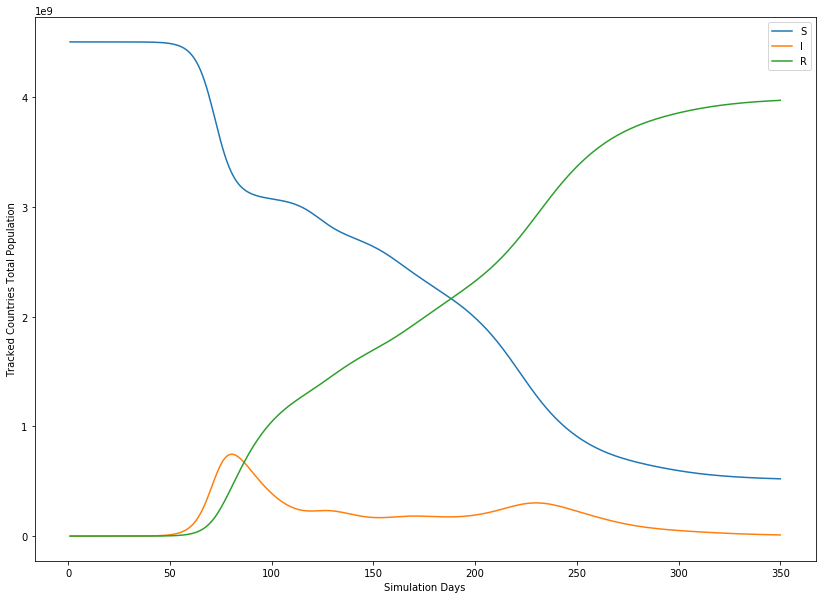

In [10]:
# World total
print("World")
plt.figure(figsize=(14,10))
plt.plot(list(range(1, T+1)), [np.array([S_lists[c][d] for c in countries]).sum() for d in range(T)], label="S")
plt.plot(list(range(1, T+1)), [np.array([I_lists[c][d] for c in countries]).sum() for d in range(T)], label="I")
plt.plot(list(range(1, T+1)), [np.array([R_lists[c][d] for c in countries]).sum() for d in range(T)], label="R")
plt.legend()
plt.xlabel('Simulation Days')
plt.ylabel('Tracked Countries Total Population')
plt.savefig(open("world-simulation.png", "wb"))

In [11]:
# Country betas; higher beta should give peak earlier
{k: v for k, v in sorted(country_betas.items(), key=lambda item: -item[1])}

{'Spain': 0.3014995166850214,
 'South Korea': 0.29978333939800106,
 'Israel': 0.2895537742427694,
 'China': 0.27633667502088555,
 'Lebanon': 0.2738308504179704,
 'Iran': 0.2474857354469653,
 'United States': 0.23106117112797023,
 'Germany': 0.22550139695005025,
 'Belgium': 0.21900816308839532,
 'Italy': 0.21345674586006005,
 'United Kingdom': 0.2089733041047812,
 'Finland': 0.20339912582097963,
 'Oman': 0.1946280571280571,
 'France': 0.19073039934871855,
 'Canada': 0.19018239797991365,
 'Sweden': 0.18876902161374992,
 'Egypt': 0.18582932767715377,
 'Afghanistan': 0.1847112323302799,
 'Russia': 0.18372965323810656,
 'Philippines': 0.183272375520404,
 'Iraq': 0.17625729701580362,
 'India': 0.17377175089900604,
 'Cambodia': 0.1637907061526249,
 'Australia': 0.15940278191783444,
 'Japan': 0.15325524542392013,
 'Malaysia': 0.14698897909420355,
 'Kuwait': 0.13692363632839818,
 'Singapore': 0.13391078850057178,
 'United Arab Emirates': 0.13147516919907454,
 'Bahrain': 0.12816939825453758,
 'T

In [12]:
# For each country which simulation day sees the pick 
countries_peak_day = {c: I_lists[c].index(max(I_lists[c])) for c in countries}
{k: v for k, v in sorted(countries_peak_day.items(), key=lambda item: item[1])}

{'China': 79,
 'South Korea': 87,
 'United States': 130,
 'Israel': 138,
 'Macau': 150,
 'Sweden': 153,
 'Japan': 164,
 'Spain': 165,
 'Canada': 169,
 'Iran': 169,
 'Lebanon': 172,
 'Russia': 175,
 'United Kingdom': 183,
 'Italy': 186,
 'Cambodia': 191,
 'Australia': 196,
 'Taiwan': 197,
 'Hong Kong': 200,
 'Germany': 204,
 'France': 217,
 'Malaysia': 219,
 'Finland': 222,
 'Belgium': 222,
 'Oman': 229,
 'India': 231,
 'United Arab Emirates': 233,
 'Sri Lanka': 238,
 'Singapore': 241,
 'Thailand': 245,
 'Philippines': 258,
 'Afghanistan': 263,
 'Kuwait': 284,
 'Vietnam': 291,
 'Egypt': 297,
 'Bahrain': 303,
 'Iraq': 307,
 'Nepal': 345}

In [13]:
# Calculate Percentage change in total population for each country
pct_values = []
for c in countries:
    final_population = S_lists[c][-1] + I_lists[c][-1] + R_lists[c][-1]
    pct_change = ((final_population - country_populations[c]) / country_populations[c])*100
    pct_values.append(pct_change)
    print(c, pct_change)
np.array(pct_values).mean()

South Korea -1.020943790543966
Israel -1.1024548950307136
Philippines -0.009645564934863626
United States 0.12042085909265857
United Kingdom -5.477626799985128
Singapore 5.464201831286298
Sweden 3.976048936126219
Italy 0.4487986854502308
France -2.767068879700298
Finland -4.538542979728334
Vietnam 0.0554772727001143
Russia -0.15725059633935573
Macau 43.43040817642566
Taiwan -2.259871640040518
Japan -0.4320123722751932
Malaysia -0.3055315340553706
Thailand -0.9668273045385894
Germany -1.7382177675302521
Australia -1.4830955882730754
United Arab Emirates -4.028173293323172
Canada 6.705396975811083
Bahrain 8.466166442022265
Iran 0.11745420604276896
Belgium -4.998072879868732
China 0.17229903304004165
Spain 9.590647318721688
Hong Kong -3.241988184189714
Sri Lanka -0.479856136574186
Kuwait -1.2737573042041292
Oman -0.7993771668449987
Lebanon -0.4432530686113879
Iraq -0.07520354267961231
Egypt 0.013478803387654854
Cambodia 0.03793964978168385
India 0.027987157108728948
Nepal -0.0615186964499

1.110617393260738

World


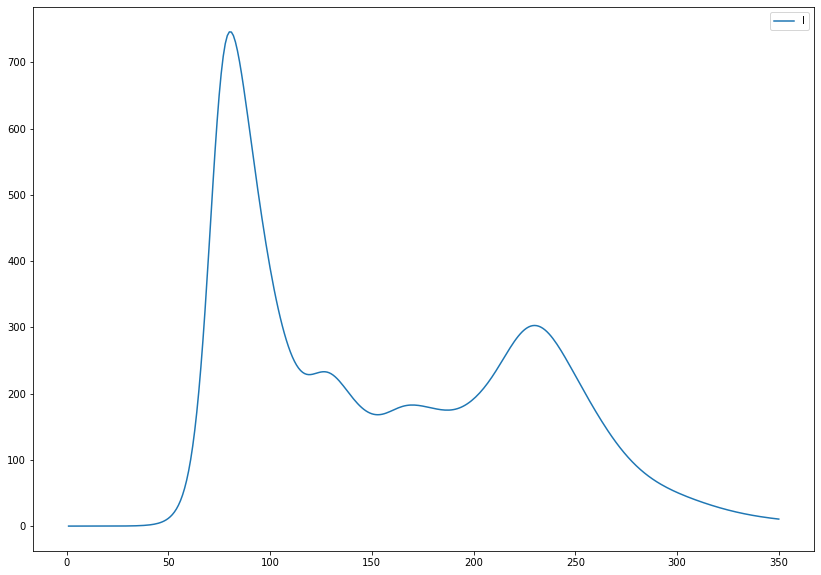

In [14]:
# World total Infected (1/1000000)
print("World")
plt.figure(figsize=(14,10))
plt.plot(list(range(1, T+1)), [np.array([I_lists[c][d] for c in countries]).sum()/1000000 for d in range(T)], label="I")
plt.legend()
plt.show()

## Simulation with travel restrictions
Significantly reduce international air traffic after a number of days that registered confirmed cases.

In [15]:
# Simulation with travel restrictions
S_lists_tr = {}
I_lists_tr = {}
R_lists_tr = {}

# Initialise lists values
for c in countries:
    S_lists_tr[c] = [ country_populations[c] ]
    I_lists_tr[c] = [ confirmed.loc[c, confirmed.columns[0]] ]
    R_lists_tr[c] = [ deaths.loc[c, deaths.columns[0]] ]
    
# Percentage of air traffic retained
air_traffic_perc = 0.1
# Days with confirmed cases after which apply travel restrictions
days_with_cases = 10

# Carry out simulation
for t in range(1, T):
    for c in countries:
        # Get people coming into the country for each compartment
        S_in_t = 0
        I_in_t = 0
        R_in_t = 0
        for n in g.nodes():
            if g.get_edge_data(n, c) is not None:
                if t >= days_with_cases and I_lists_tr[c][-days_with_cases] > 1:
                    n_in_route = g.get_edge_data(n, c)['weight'] * air_traffic_perc
                else: 
                    n_in_route = g.get_edge_data(n, c)['weight']
                n_total_pop = S_lists_tr[n][t-1] + I_lists_tr[n][t-1] + R_lists_tr[n][t-1]
                n_in_population = n_in_route * np.log10(n_total_pop)
                S_in_t += (S_lists_tr[n][t-1] / n_total_pop) * n_in_population
                I_in_t += (I_lists_tr[n][t-1] / n_total_pop) * n_in_population
                R_in_t += (R_lists_tr[n][t-1] / n_total_pop) * n_in_population
        # Get people going out of the country for each compartment
        current_population = S_lists_tr[c][t-1] + I_lists_tr[c][t-1] + R_lists_tr[c][t-1]
        if t >= days_with_cases and I_lists_tr[c][-days_with_cases] > 1:
            out_population = air_traffic_perc * out_routes[c] * np.log10(current_population)
        else:
            out_population = out_routes[c] * np.log10(current_population)
        S_out_t = (S_lists_tr[c][t-1] / current_population) * out_population
        I_out_t = (I_lists_tr[c][t-1] / current_population) * out_population
        R_out_t = (R_lists_tr[c][t-1] / current_population) * out_population

        S_t = S_lists_tr[c][t-1] - ((S_lists_tr[c][t-1] / S_lists_tr[c][0]) * (country_betas[c]*I_lists_tr[c][t-1]))
        S_lists_tr[c].append(S_t - S_out_t + S_in_t)
        
        I_t = I_lists_tr[c][t-1] + ((S_lists_tr[c][t-1] / S_lists_tr[c][0]) * (country_betas[c]*I_lists_tr[c][t-1])) - (I_lists_tr[c][t-1] * country_gammas[c])
        I_lists_tr[c].append(I_t - I_out_t + I_in_t)
        
        R_t = R_lists_tr[c][t-1] + (I_lists_tr[c][t-1] * country_gammas[c])
        R_lists_tr[c].append(R_t - R_out_t + R_in_t)
        
      

World


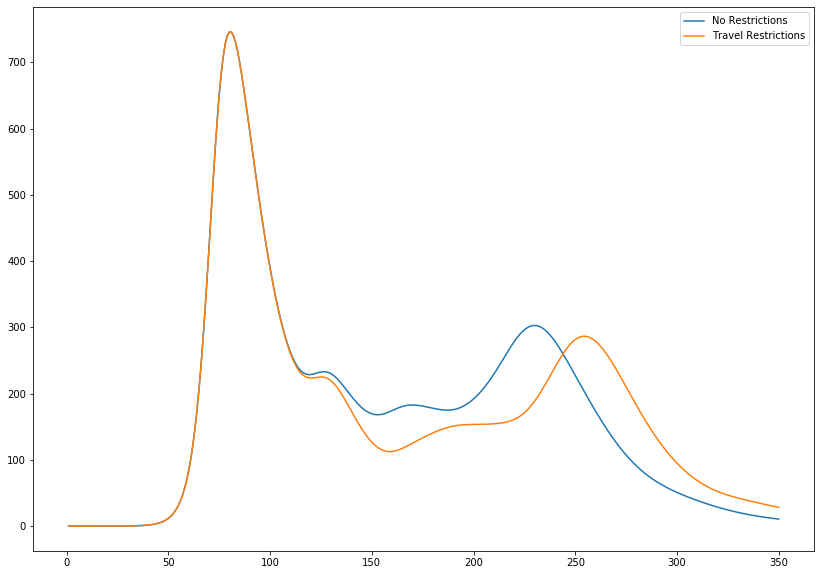

In [16]:
# World total Infected (1/1000000)
print("World")
plt.figure(figsize=(14,10))
plt.plot(list(range(1, T+1)), [np.array([I_lists[c][d] for c in countries]).sum()/1000000 for d in range(T)], label="No Restrictions")
plt.plot(list(range(1, T+1)), [np.array([I_lists_tr[c][d] for c in countries]).sum()/1000000 for d in range(T)], label="Travel Restrictions")
plt.legend()
plt.show()

South Korea


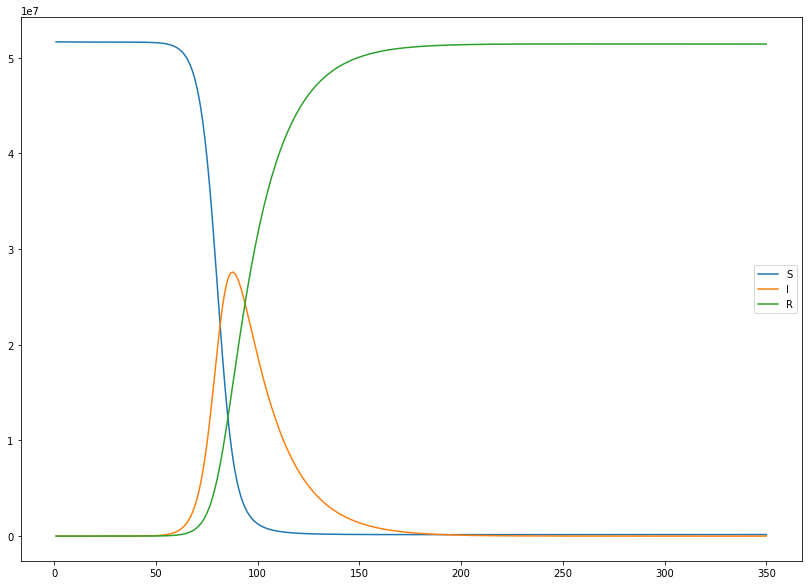

Israel


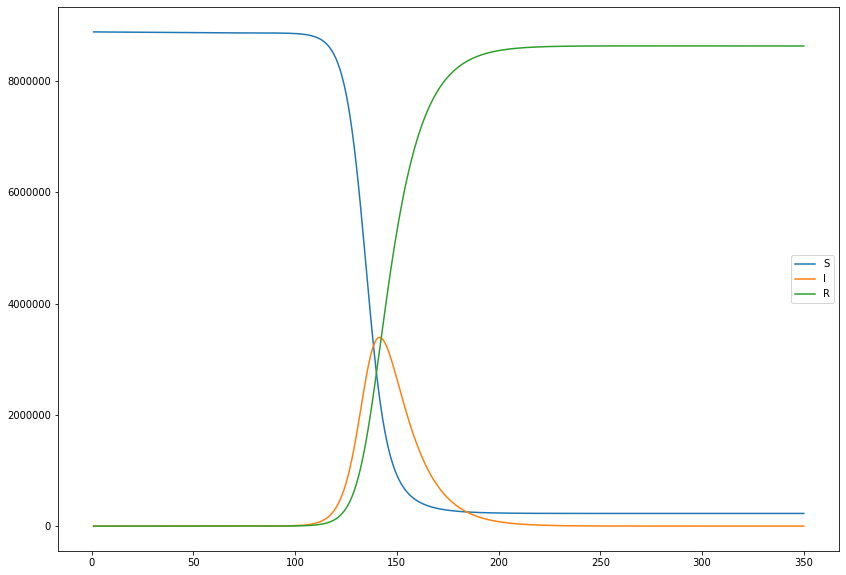

Philippines


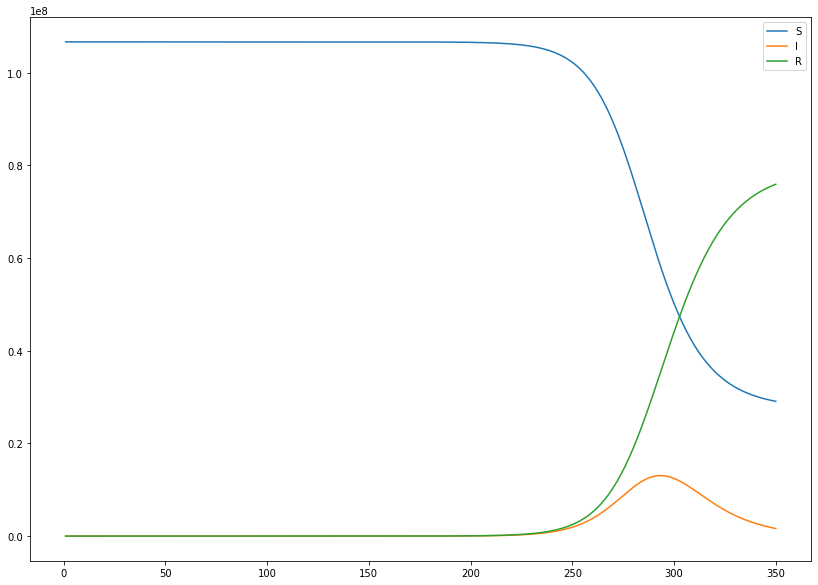

United States


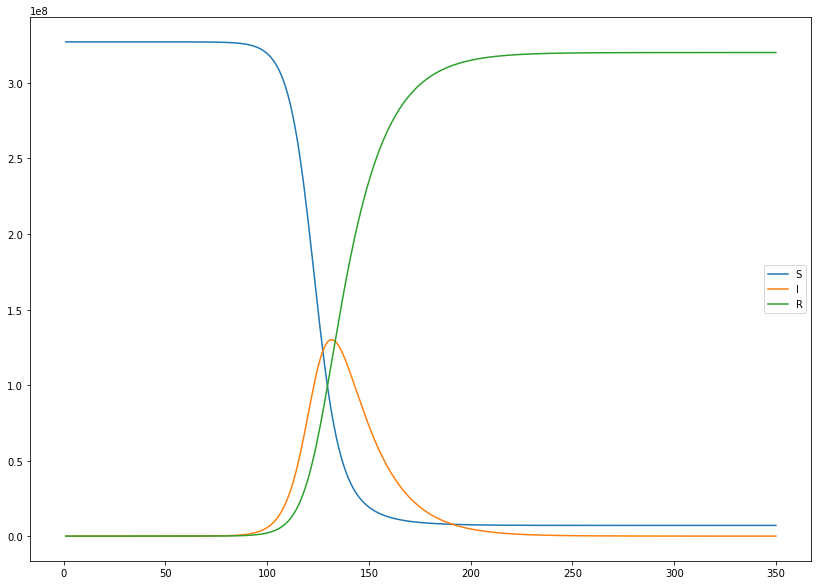

United Kingdom


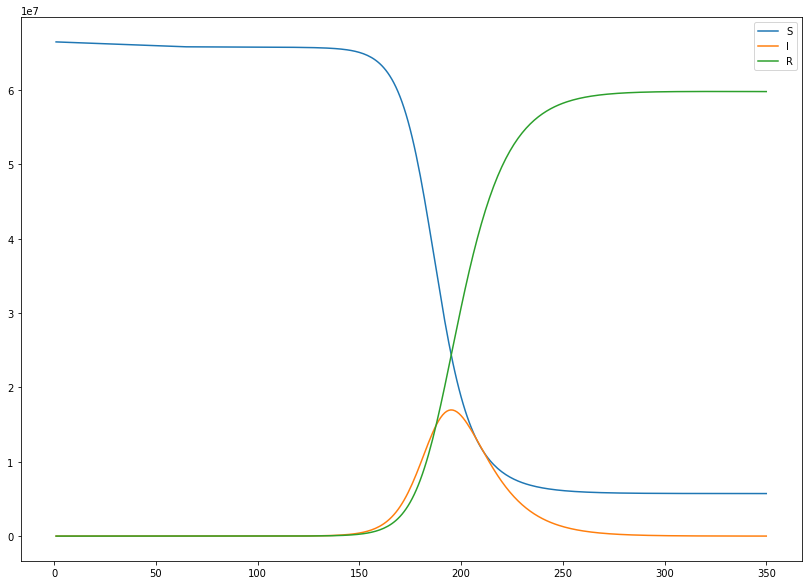

Singapore


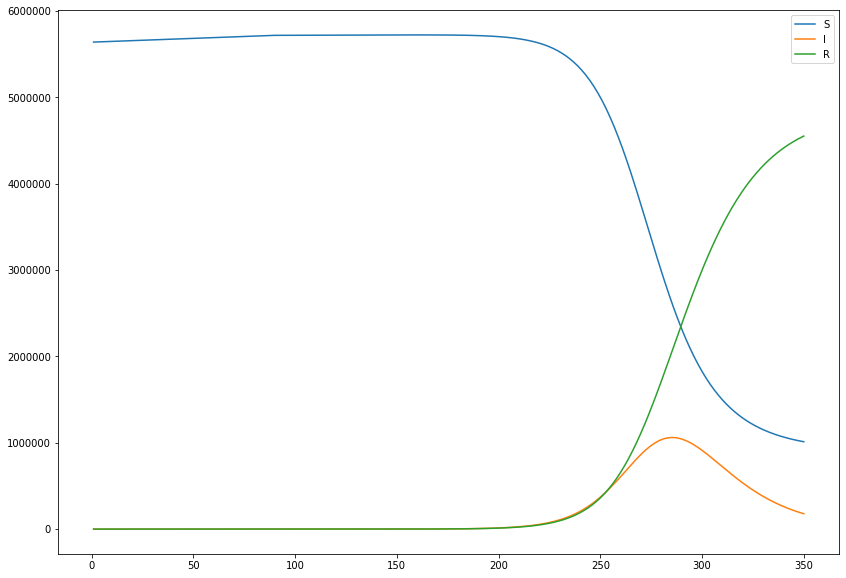

Sweden


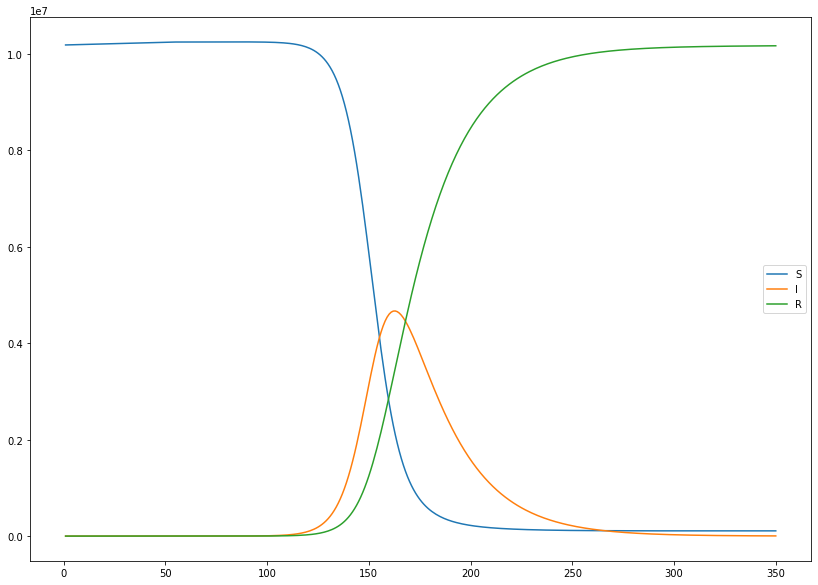

Italy


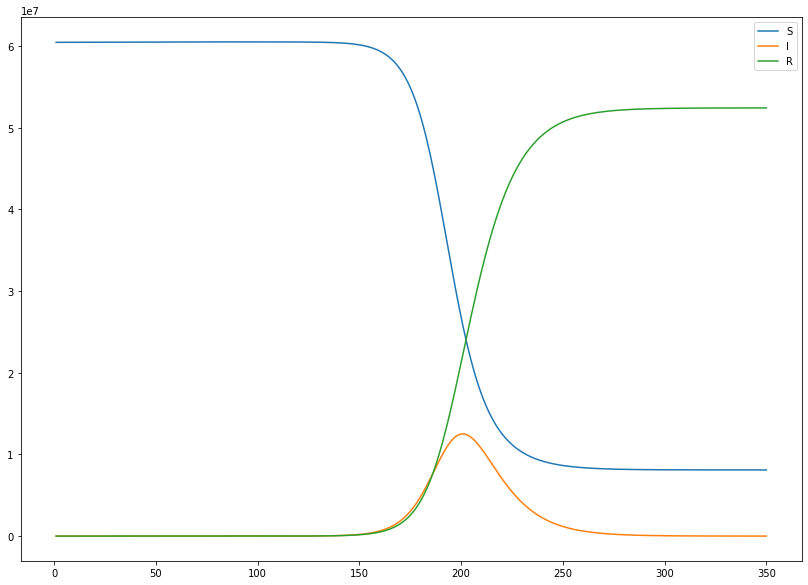

France


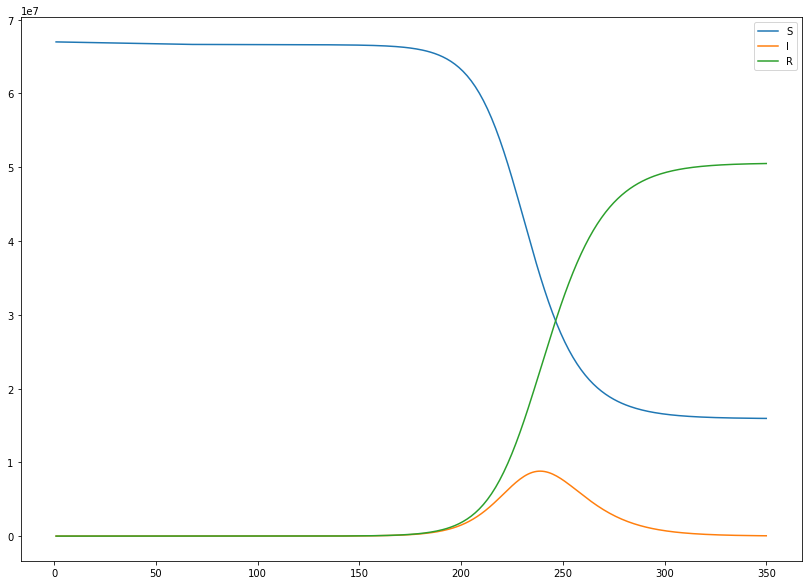

Finland


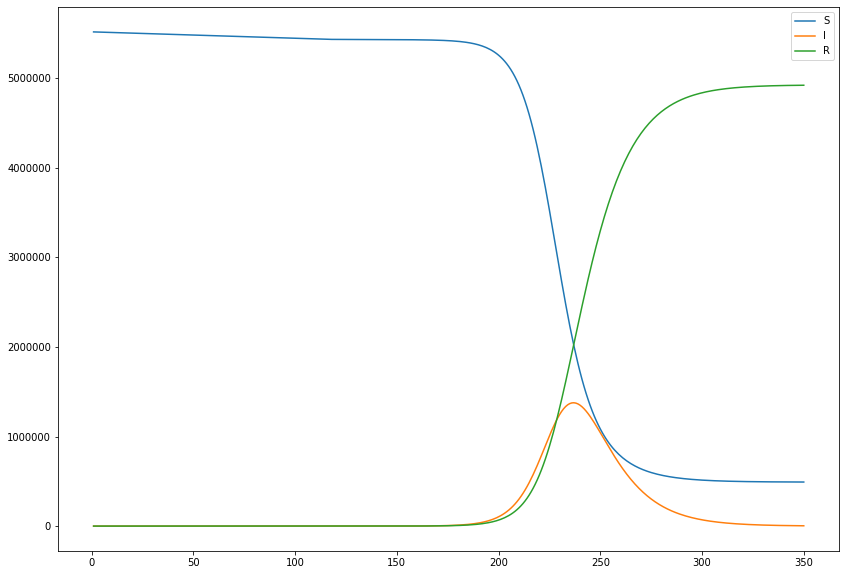

Vietnam


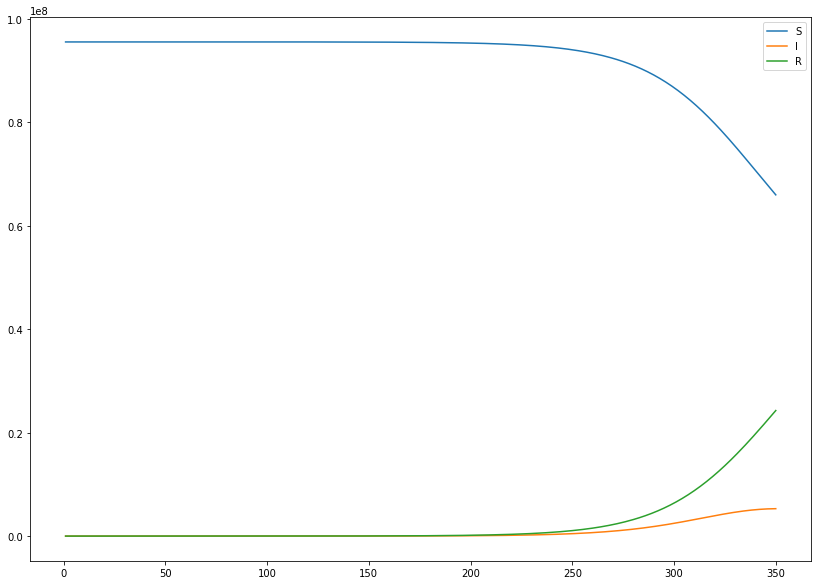

Russia


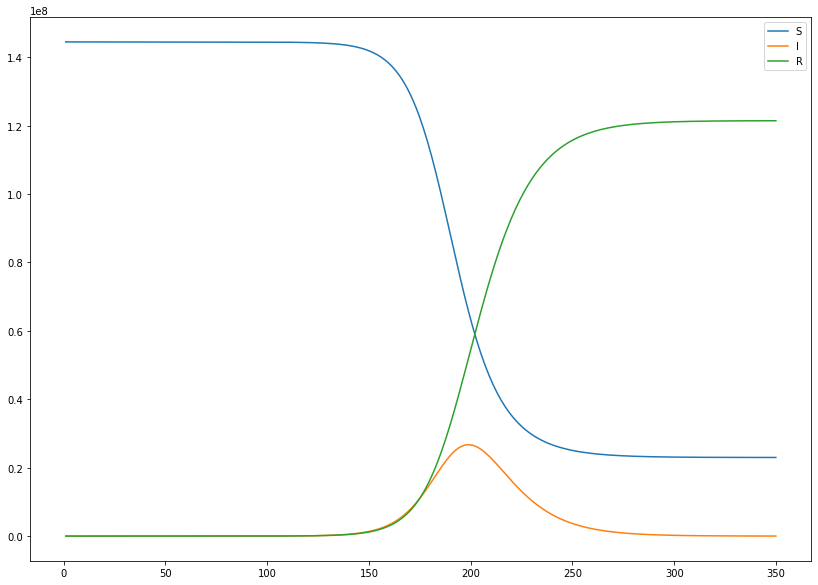

Macau


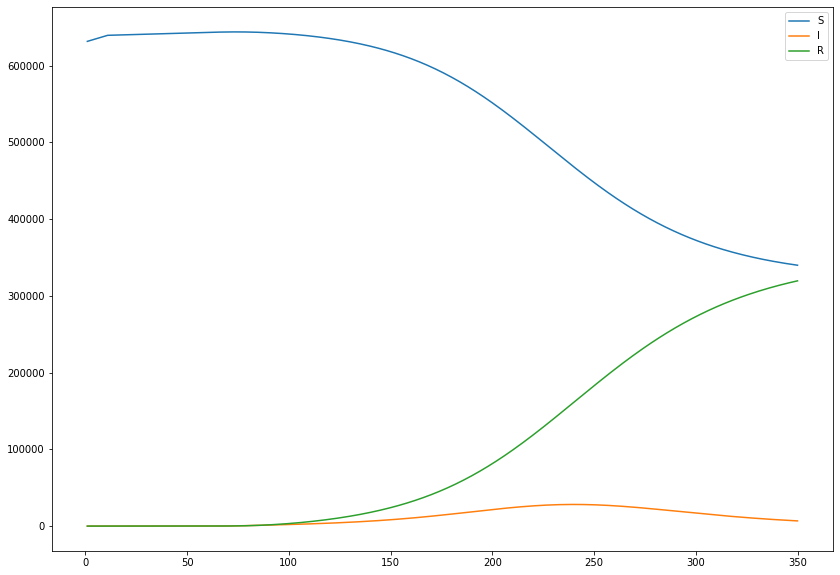

Taiwan


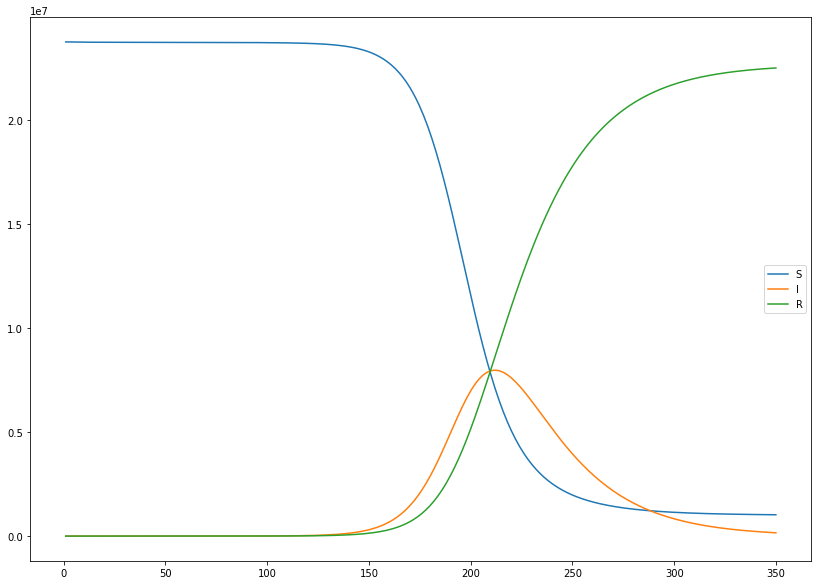

Japan


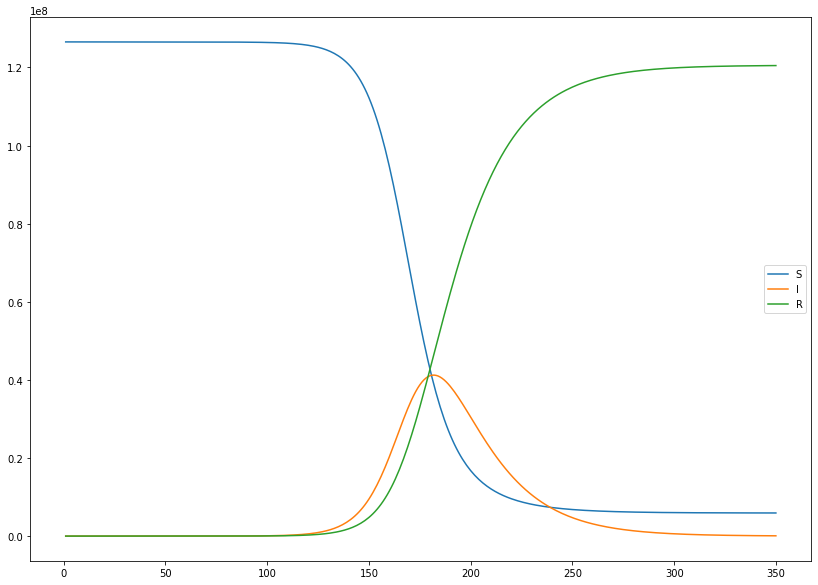

Malaysia


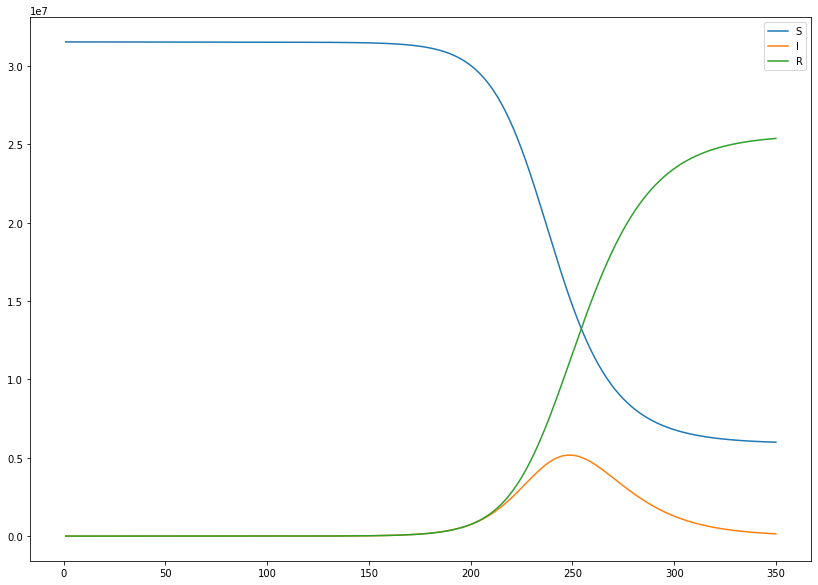

Thailand


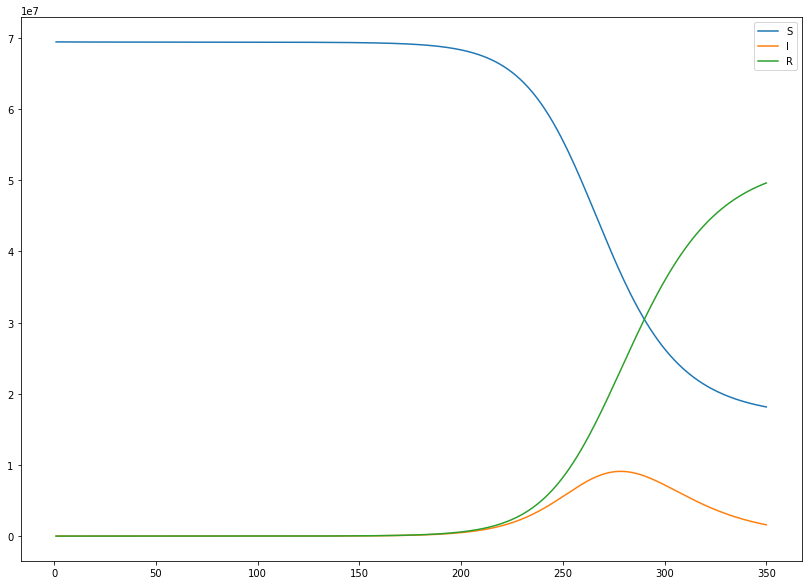

Germany


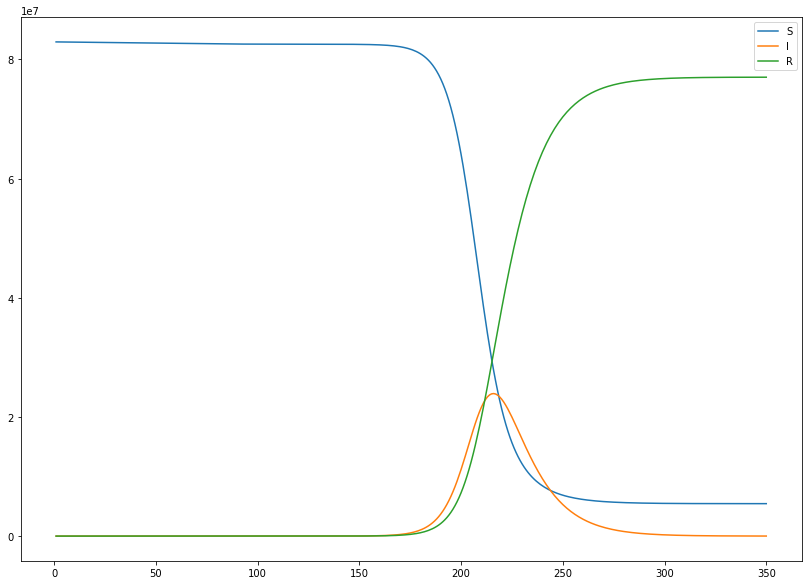

Australia


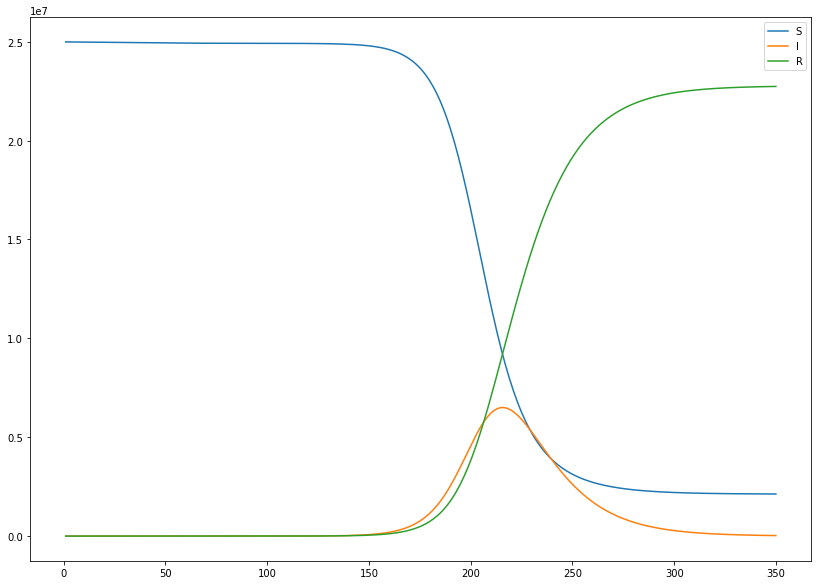

United Arab Emirates


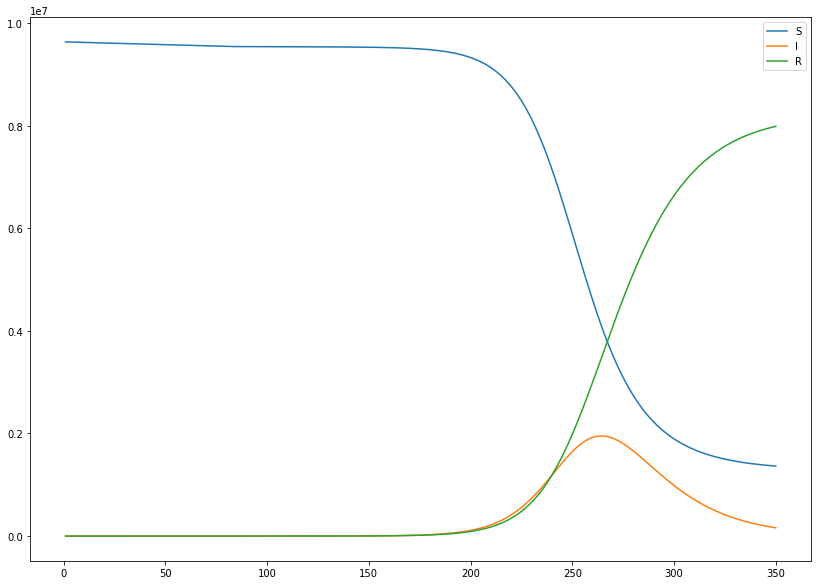

Canada


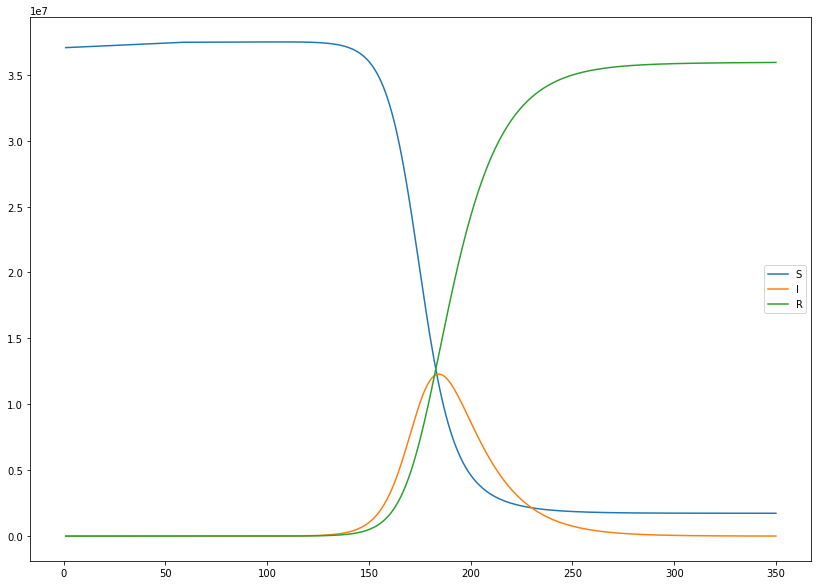

Bahrain


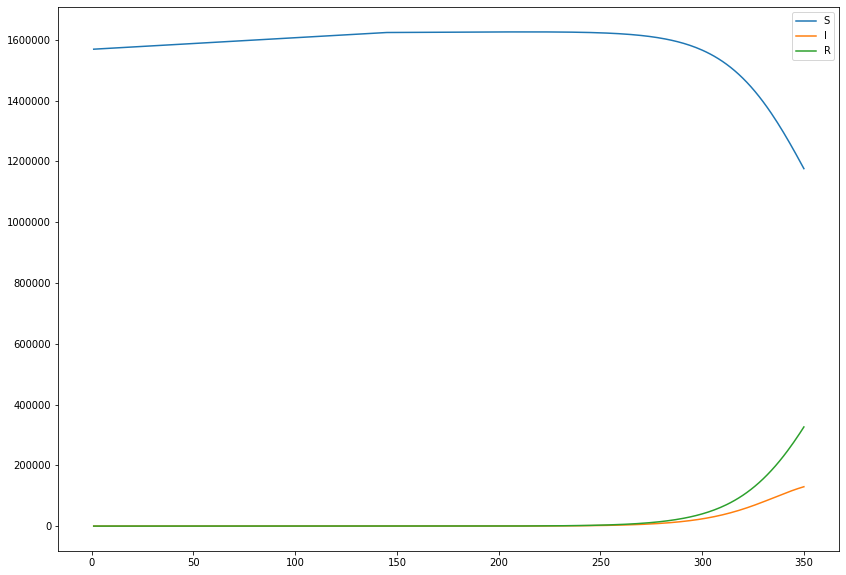

Iran


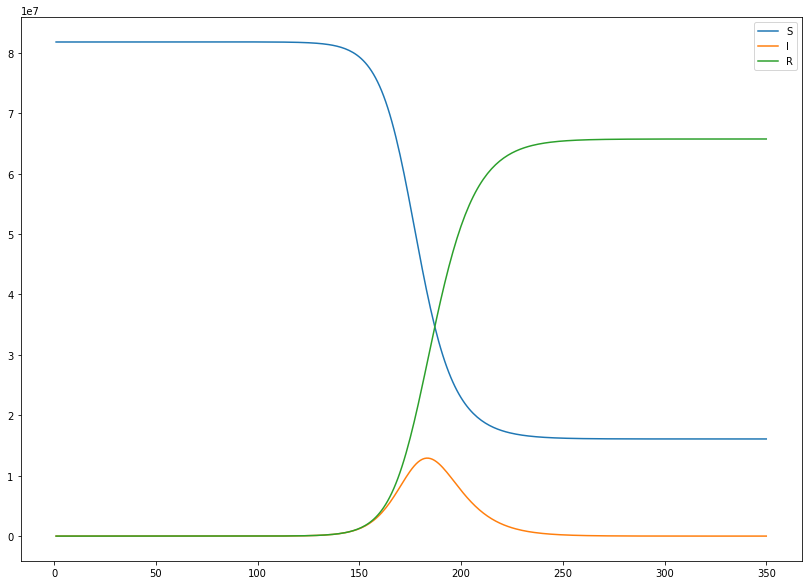

Belgium


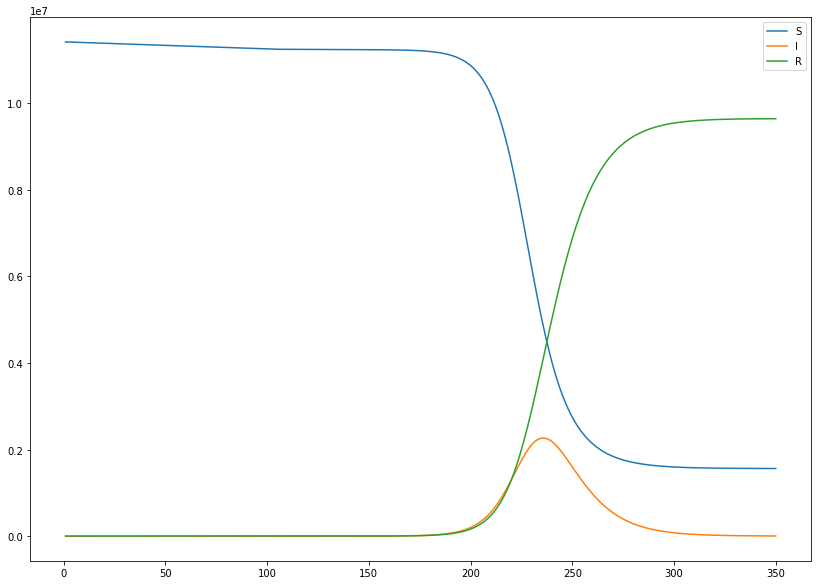

China


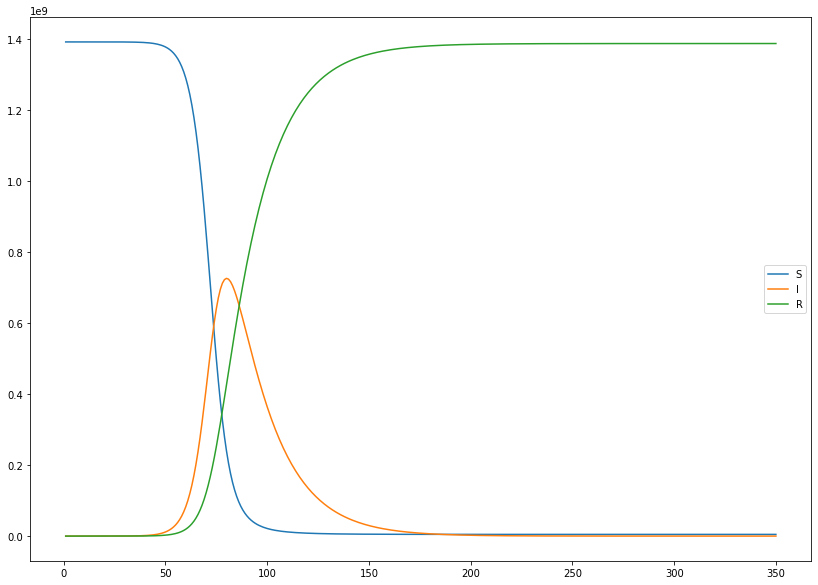

Spain


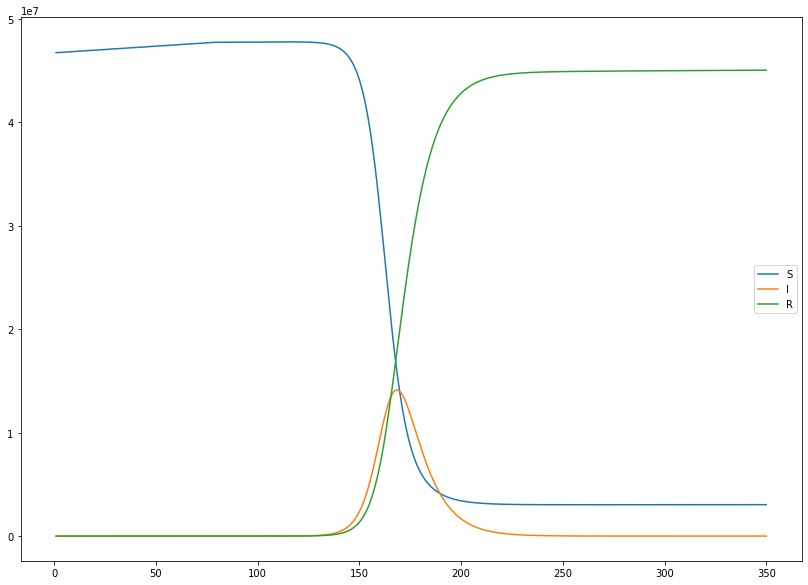

Hong Kong


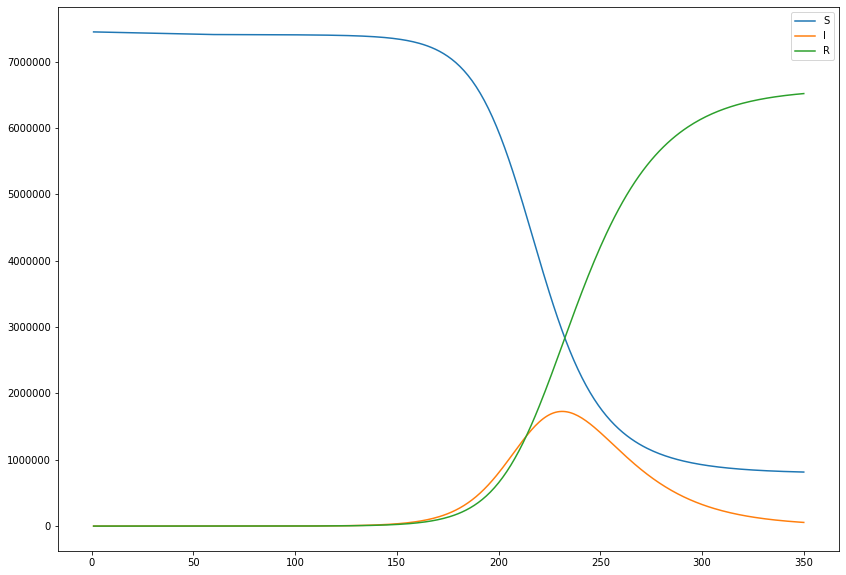

Sri Lanka


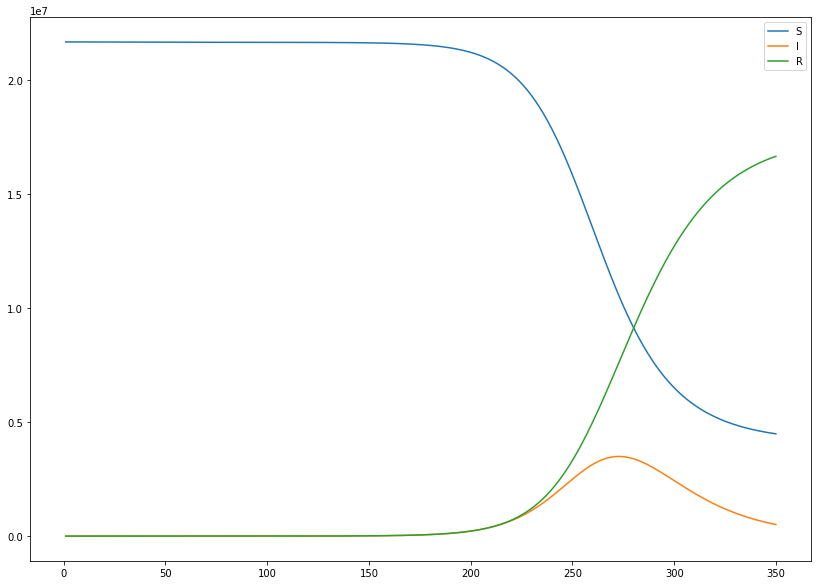

Kuwait


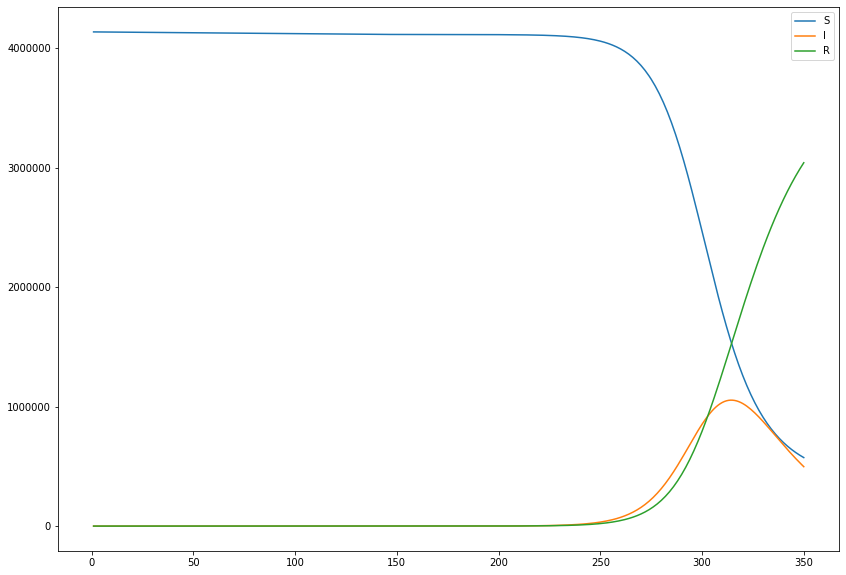

Oman


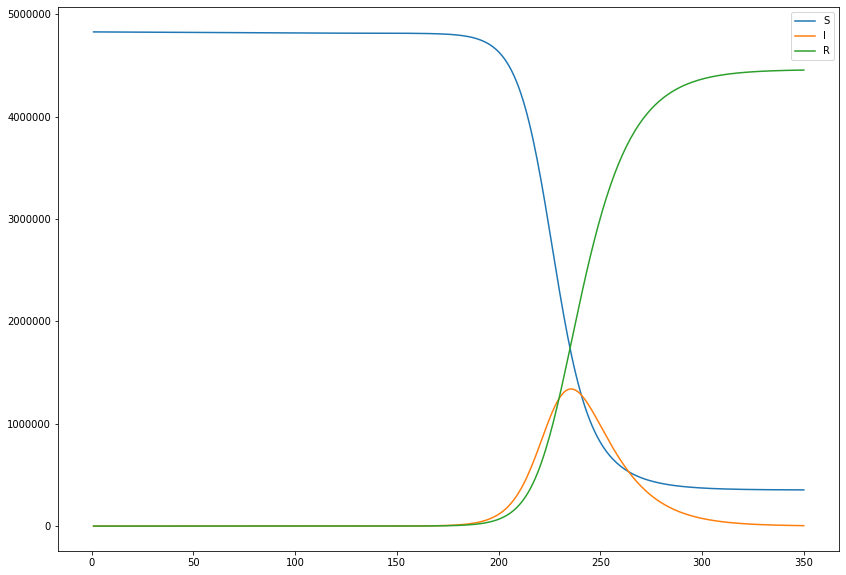

Lebanon


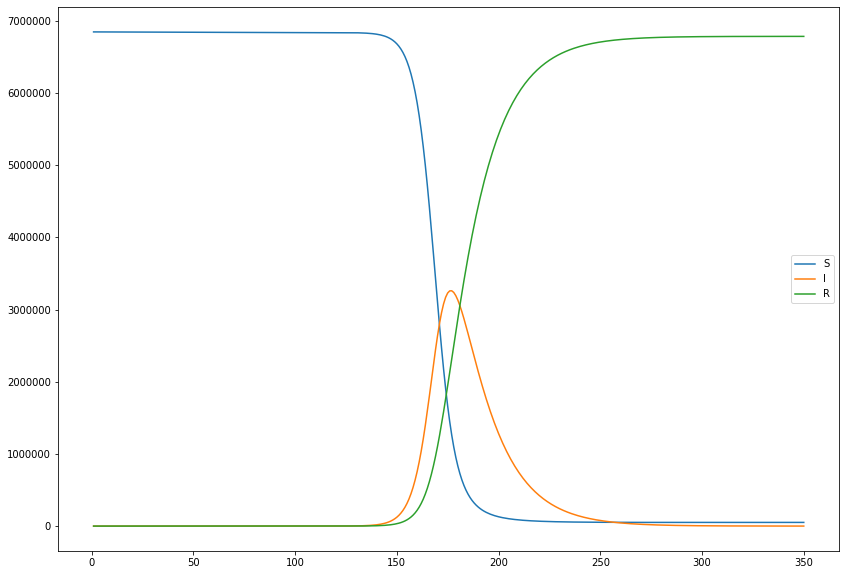

Iraq


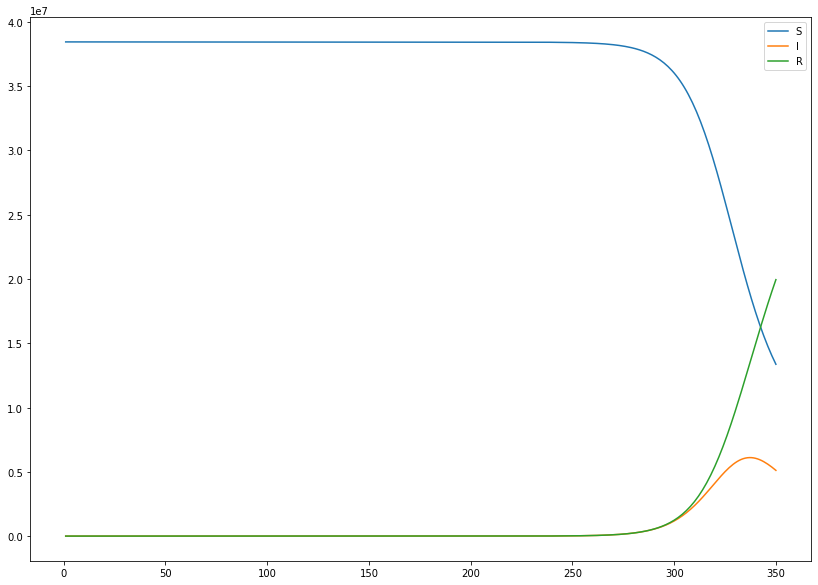

Egypt


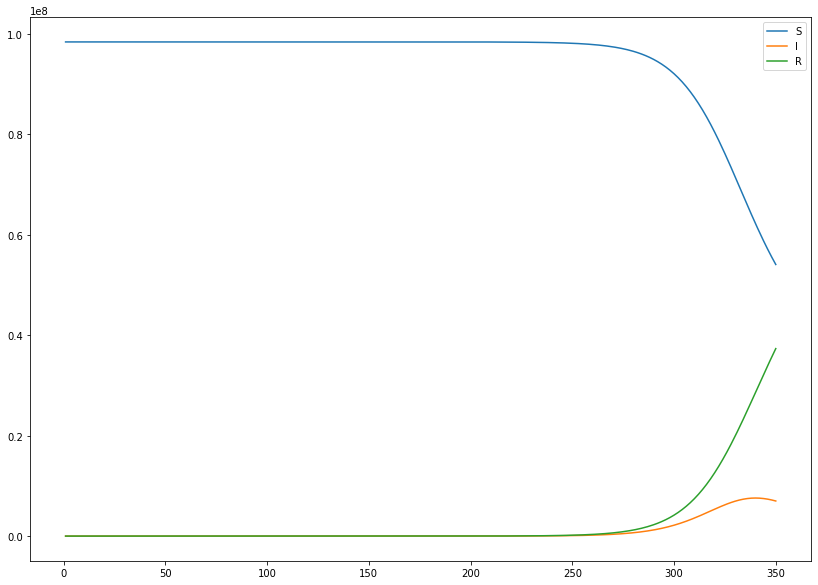

Cambodia


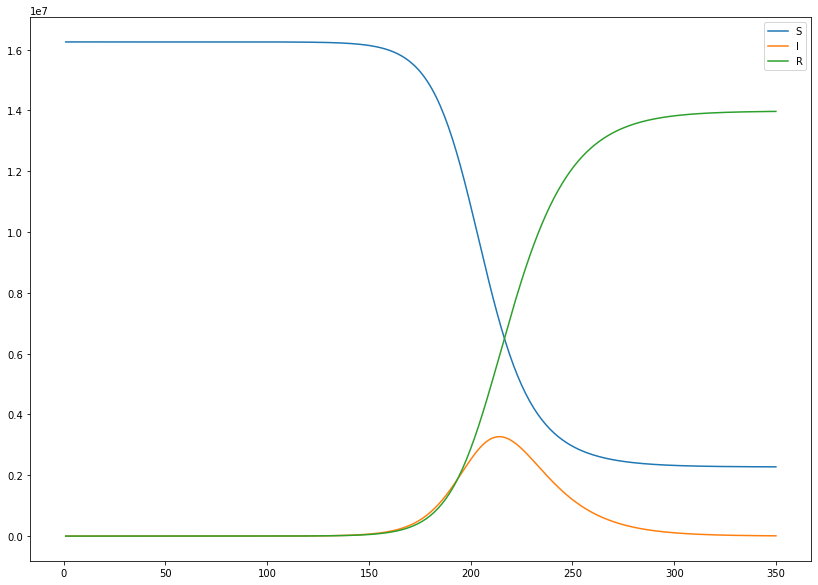

India


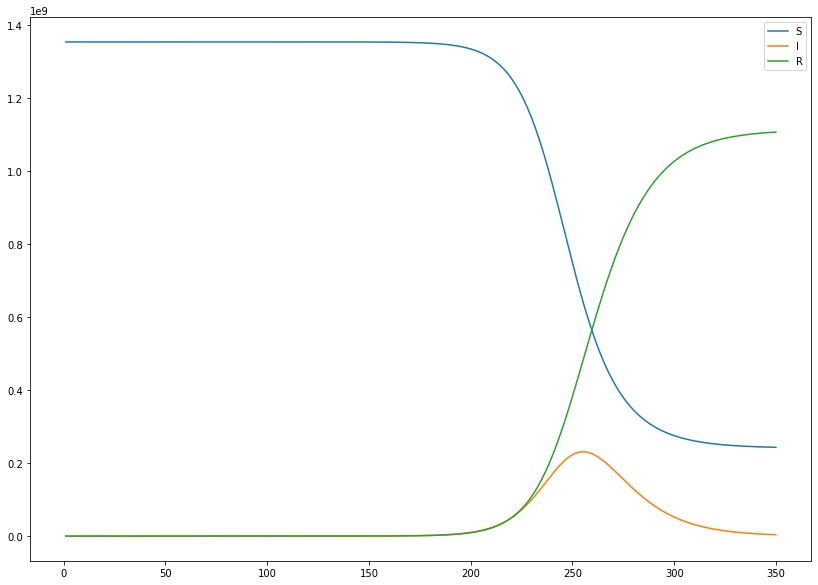

Nepal


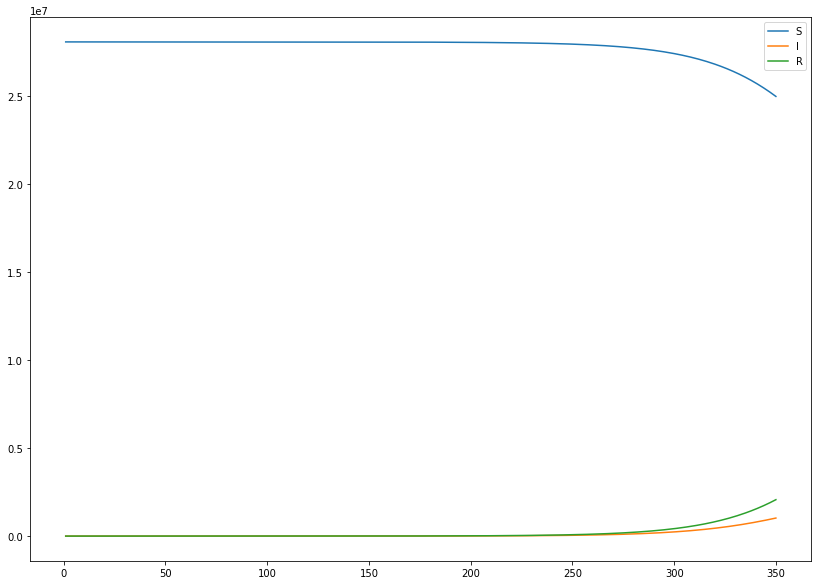

Afghanistan


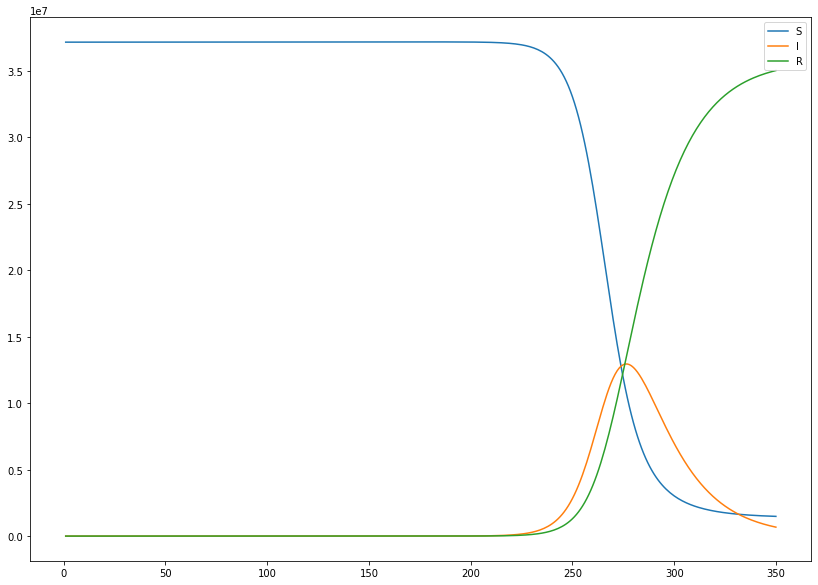

In [17]:
# Visualize simulation results
x = list(range(T))
for c in countries:
    print(c)
    plt.figure(figsize=(14,10))
    plt.plot(list(range(1, T+1)), S_lists_tr[c], label="S")
    plt.plot(list(range(1, T+1)), I_lists_tr[c], label="I")
    plt.plot(list(range(1, T+1)), R_lists_tr[c], label="R")
    plt.legend()
    plt.show()

In [18]:
# Show how travel restrictions delayed the peak for each country
countries_peak_day_tr = {c: I_lists_tr[c].index(max(I_lists_tr[c])) for c in countries}
countries_peak_delay_tr = {k: countries_peak_day_tr[k]-v for k, v in countries_peak_day.items()}

{k: v for k, v in sorted(countries_peak_delay_tr.items(), key=lambda item: item[1])}

{'South Korea': 0,
 'China': 0,
 'United States': 1,
 'Spain': 2,
 'Israel': 3,
 'Lebanon': 4,
 'Nepal': 4,
 'Oman': 6,
 'Sweden': 9,
 'United Kingdom': 11,
 'Germany': 11,
 'Iran': 13,
 'Belgium': 13,
 'Afghanistan': 13,
 'Italy': 14,
 'Finland': 14,
 'Taiwan': 14,
 'Canada': 14,
 'Japan': 17,
 'Australia': 19,
 'France': 21,
 'Cambodia': 22,
 'Russia': 23,
 'India': 23,
 'Malaysia': 29,
 'Kuwait': 29,
 'Iraq': 29,
 'United Arab Emirates': 30,
 'Hong Kong': 30,
 'Thailand': 32,
 'Philippines': 34,
 'Sri Lanka': 34,
 'Egypt': 42,
 'Singapore': 43,
 'Bahrain': 46,
 'Vietnam': 58,
 'Macau': 89}

## Simulation with lockdown
Isolation of individuals is applied by reducing the percentage of the population in the Susceptible compartment after a number of days with confirmed cases.

In [19]:
# Simulation with travel restrictions
S_lists_lock = {}
I_lists_lock = {}
R_lists_lock = {}

# Initialise lists values
for c in countries:
    S_lists_lock[c] = [ country_populations[c] ]
    I_lists_lock[c] = [ confirmed.loc[c, confirmed.columns[0]] ]
    R_lists_lock[c] = [ deaths.loc[c, deaths.columns[0]] ]
    
# Percentage of people still normally circulating
isolation_perc = 0.6
# Days with confirmed cases after which apply lockdown
days_with_cases = 10

# Carry out simulation
for t in range(1, T):
    for c in countries:
        # Get people coming into the country for each compartment
        S_in_t = 0
        I_in_t = 0
        R_in_t = 0
        for n in g.nodes():
            if g.get_edge_data(n, c) is not None:
                n_in_route = g.get_edge_data(n, c)['weight']
                n_total_pop = S_lists_lock[n][t-1] + I_lists_lock[n][t-1] + R_lists_lock[n][t-1]
                n_in_population = n_in_route * np.log10(n_total_pop)
                S_in_t += (S_lists_lock[n][t-1] / n_total_pop) * n_in_population
                I_in_t += (I_lists_lock[n][t-1] / n_total_pop) * n_in_population
                R_in_t += (R_lists_lock[n][t-1] / n_total_pop) * n_in_population
        # Get people going out of the country for each compartment
        current_population = S_lists_lock[c][t-1] + I_lists_lock[c][t-1] + R_lists_lock[c][t-1]
        out_population = out_routes[c] * np.log10(current_population)
        S_out_t = (S_lists_lock[c][t-1] / current_population) * out_population
        I_out_t = (I_lists_lock[c][t-1] / current_population) * out_population
        R_out_t = (R_lists_lock[c][t-1] / current_population) * out_population
    
        current_S = S_lists_lock[c][t-1]
        if t >= days_with_cases and I_lists_lock[c][-days_with_cases] > 1:
            current_S *= isolation_perc
        S_t = S_lists_lock[c][t-1] - ((current_S / S_lists_lock[c][0]) * (country_betas[c]*I_lists_lock[c][t-1])) 
        S_lists_lock[c].append(S_t - S_out_t + S_in_t)
        
        I_t = I_lists_lock[c][t-1] + ((current_S / S_lists_lock[c][0]) * (country_betas[c]*I_lists_lock[c][t-1])) - (I_lists_lock[c][t-1] * country_gammas[c])
        I_lists_lock[c].append(I_t - I_out_t + I_in_t)
        
        R_t = R_lists_lock[c][t-1] + (I_lists_lock[c][t-1] * country_gammas[c])
        R_lists_lock[c].append(R_t - R_out_t + R_in_t)
        
      

World


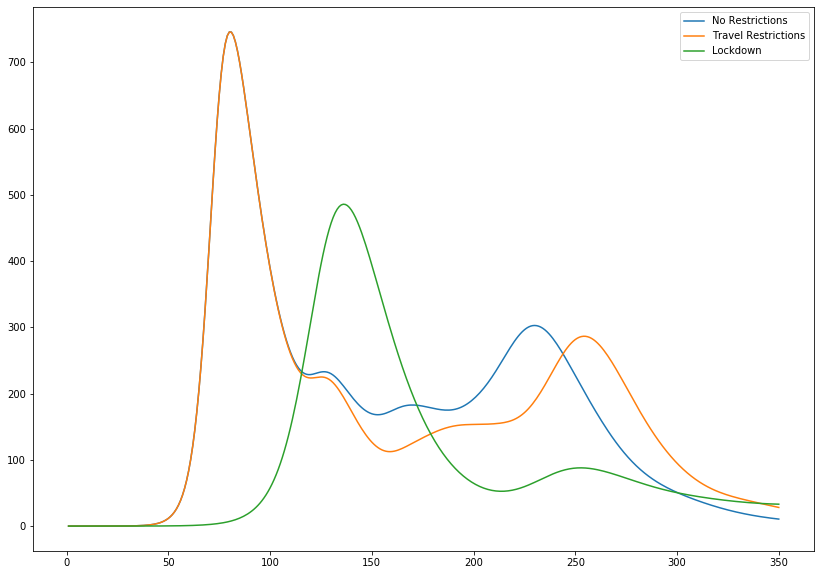

In [20]:
# World total Infected (1/1000000)
print("World")
plt.figure(figsize=(14,10))
plt.plot(list(range(1, T+1)), [np.array([I_lists[c][d] for c in countries]).sum()/1000000 for d in range(T)], label="No Restrictions")
plt.plot(list(range(1, T+1)), [np.array([I_lists_tr[c][d] for c in countries]).sum()/1000000 for d in range(T)], label="Travel Restrictions")
plt.plot(list(range(1, T+1)), [np.array([I_lists_lock[c][d] for c in countries]).sum()/1000000 for d in range(T)], label="Lockdown")
plt.legend()
plt.show()

In [21]:
# Show how isolation restrictions delayed the peak for each country
countries_peak_day_lock = {c: I_lists_lock[c].index(max(I_lists_lock[c])) for c in countries}
countries_peak_delay_lock = {k: countries_peak_day_lock[k]-v for k, v in countries_peak_day.items()}

{k: v for k, v in sorted(countries_peak_delay_lock.items(), key=lambda item: item[1])}

{'Nepal': -150,
 'Vietnam': -119,
 'Macau': 26,
 'Iraq': 42,
 'Bahrain': 46,
 'Egypt': 52,
 'China': 56,
 'South Korea': 61,
 'Kuwait': 65,
 'Lebanon': 73,
 'Afghanistan': 86,
 'Philippines': 91,
 'Israel': 92,
 'Thailand': 104,
 'Singapore': 108,
 'Spain': 110,
 'Sweden': 111,
 'Sri Lanka': 111,
 'United Arab Emirates': 116,
 'India': 118,
 'United States': 120,
 'Oman': 120,
 'Finland': 127,
 'Belgium': 127,
 'Malaysia': 130,
 'France': 132,
 'Germany': 145,
 'Canada': 146,
 'Japan': 147,
 'Hong Kong': 149,
 'Taiwan': 152,
 'Australia': 153,
 'Cambodia': 158,
 'Italy': 163,
 'United Kingdom': 166,
 'Russia': 174,
 'Iran': 180}

In [22]:
countries_peak_day_lock

{'South Korea': 148,
 'Israel': 230,
 'Philippines': 349,
 'United States': 250,
 'United Kingdom': 349,
 'Singapore': 349,
 'Sweden': 264,
 'Italy': 349,
 'France': 349,
 'Finland': 349,
 'Vietnam': 172,
 'Russia': 349,
 'Macau': 176,
 'Taiwan': 349,
 'Japan': 311,
 'Malaysia': 349,
 'Thailand': 349,
 'Germany': 349,
 'Australia': 349,
 'United Arab Emirates': 349,
 'Canada': 315,
 'Bahrain': 349,
 'Iran': 349,
 'Belgium': 349,
 'China': 135,
 'Spain': 275,
 'Hong Kong': 349,
 'Sri Lanka': 349,
 'Kuwait': 349,
 'Oman': 349,
 'Lebanon': 245,
 'Iraq': 349,
 'Egypt': 349,
 'Cambodia': 349,
 'India': 349,
 'Nepal': 195,
 'Afghanistan': 349}

## Simulation with Isolation of infected
Isolation of infected individuals is modelled by removing a percentage of the Infected compartment.

In [23]:
# Simulation with travel restrictions
S_lists_iso = {}
I_lists_iso = {}
R_lists_iso = {}

# Initialise lists values
for c in countries:
    S_lists_iso[c] = [ country_populations[c] ]
    I_lists_iso[c] = [ confirmed.loc[c, confirmed.columns[0]] ]
    R_lists_iso[c] = [ deaths.loc[c, deaths.columns[0]] ]
    
# Percentage of infected not isolated
isolation_perc = 0.95
# Days with confirmed cases after which apply lockdown
days_with_cases = 10

# Carry out simulation
for t in range(1, T):
    for c in countries:
        # Get people coming into the country for each compartment
        S_in_t = 0
        I_in_t = 0
        R_in_t = 0
        for n in g.nodes():
            if g.get_edge_data(n, c) is not None:
                n_in_route = g.get_edge_data(n, c)['weight']
                n_total_pop = S_lists_iso[n][t-1] + I_lists_iso[n][t-1] + R_lists_iso[n][t-1]
                n_in_population = n_in_route * np.log10(n_total_pop)
                S_in_t += (S_lists_iso[n][t-1] / n_total_pop) * n_in_population
                I_in_t += (I_lists_iso[n][t-1] / n_total_pop) * n_in_population
                R_in_t += (R_lists_iso[n][t-1] / n_total_pop) * n_in_population
        # Get people going out of the country for each compartment
        current_population = S_lists_iso[c][t-1] + I_lists_iso[c][t-1] + R_lists_iso[c][t-1]
        out_population = out_routes[c] * np.log10(current_population)
        S_out_t = (S_lists_iso[c][t-1] / current_population) * out_population
        I_out_t = (I_lists_iso[c][t-1] / current_population) * out_population
        R_out_t = (R_lists_iso[c][t-1] / current_population) * out_population
        
        current_infected = I_lists_iso[c][t-1]
        if t >= days_with_cases and I_lists_iso[c][-days_with_cases] > 1:
            current_infected *= isolation_perc 
        S_t = S_lists_iso[c][t-1] - ((S_lists_iso[c][t-1] / S_lists_iso[c][0]) * (country_betas[c]*current_infected)) 
        S_lists_iso[c].append(S_t - S_out_t + S_in_t)
        
        I_t = current_infected + ((S_lists_iso[c][t-1] / S_lists_iso[c][0]) * (country_betas[c]*current_infected)) - (current_infected * country_gammas[c])
        I_lists_iso[c].append(I_t - I_out_t + I_in_t)
        
        R_t = R_lists_iso[c][t-1] + (current_infected * country_gammas[c])
        R_lists_iso[c].append(R_t - R_out_t + R_in_t)
        
      

World


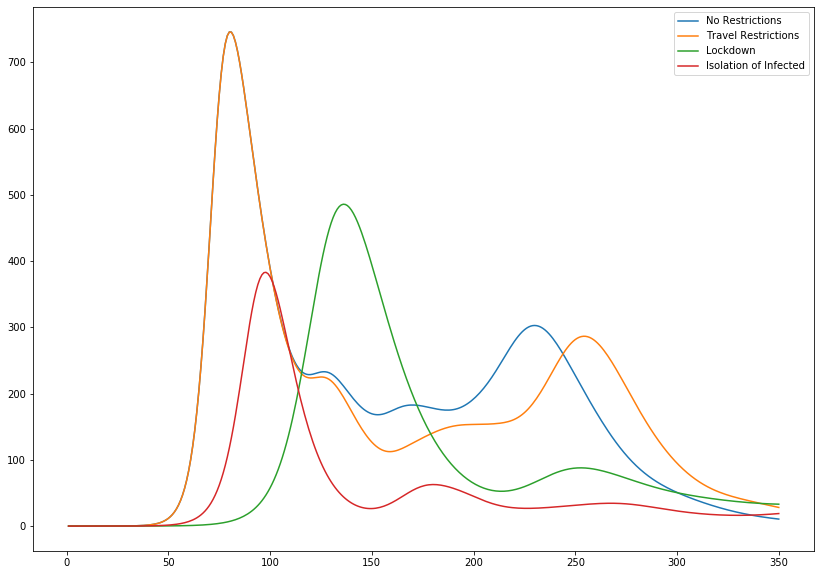

In [24]:
# World total Infected (1/1000000)
print("World")
plt.figure(figsize=(14,10))
plt.plot(list(range(1, T+1)), [np.array([I_lists[c][d] for c in countries]).sum()/1000000 for d in range(T)], label="No Restrictions")
plt.plot(list(range(1, T+1)), [np.array([I_lists_tr[c][d] for c in countries]).sum()/1000000 for d in range(T)], label="Travel Restrictions")
plt.plot(list(range(1, T+1)), [np.array([I_lists_lock[c][d] for c in countries]).sum()/1000000 for d in range(T)], label="Lockdown")
plt.plot(list(range(1, T+1)), [np.array([I_lists_iso[c][d] for c in countries]).sum()/1000000 for d in range(T)], label="Isolation of Infected")
plt.legend()
plt.show()

In [25]:
# Show how isolation restrictions delayed the peak for each country
countries_peak_day_iso = {c: I_lists_iso[c].index(max(I_lists_iso[c])) for c in countries}
countries_peak_delay_iso = {k: countries_peak_day_iso[k]-v for k, v in countries_peak_day.items()}

{k: v for k, v in sorted(countries_peak_delay_iso.items(), key=lambda item: item[1])}

{'Nepal': -223,
 'Vietnam': -166,
 'Macau': -28,
 'China': 17,
 'South Korea': 18,
 'Lebanon': 27,
 'Israel': 30,
 'Spain': 30,
 'Iraq': 42,
 'Bahrain': 46,
 'United States': 47,
 'Sweden': 51,
 'Egypt': 52,
 'Canada': 63,
 'Kuwait': 65,
 'Germany': 71,
 'Finland': 76,
 'Iran': 77,
 'United Kingdom': 81,
 'Japan': 82,
 'Italy': 84,
 'Oman': 86,
 'Afghanistan': 86,
 'Philippines': 91,
 'Belgium': 94,
 'Russia': 102,
 'Thailand': 104,
 'Singapore': 108,
 'Sri Lanka': 111,
 'Australia': 115,
 'United Arab Emirates': 116,
 'India': 118,
 'Cambodia': 119,
 'Malaysia': 130,
 'France': 132,
 'Taiwan': 142,
 'Hong Kong': 149}

# Simulation with antiviral medications
This is modelled by increasing the Gamma coefficient.

In [26]:
# Simulation with travel restrictions
S_lists_antiv = {}
I_lists_antiv = {}
R_lists_antiv = {}

# Initialise lists values
for c in countries:
    S_lists_antiv[c] = [ country_populations[c] ]
    I_lists_antiv[c] = [ confirmed.loc[c, confirmed.columns[0]] ]
    R_lists_antiv[c] = [ deaths.loc[c, deaths.columns[0]] ]
    
# Gamma increase caused by medication
gamma_increase = 0.05
# Days with confirmed cases after which apply lockdown
days_with_cases = 10

# Carry out simulation
for t in range(1, T):
    for c in countries:
        # Get people coming into the country for each compartment
        S_in_t = 0
        I_in_t = 0
        R_in_t = 0
        for n in g.nodes():
            if g.get_edge_data(n, c) is not None:
                n_in_route = g.get_edge_data(n, c)['weight']
                n_total_pop = S_lists_antiv[n][t-1] + I_lists_antiv[n][t-1] + R_lists_antiv[n][t-1]
                n_in_population = n_in_route * np.log10(n_total_pop)
                S_in_t += (S_lists_antiv[n][t-1] / n_total_pop) * n_in_population
                I_in_t += (I_lists_antiv[n][t-1] / n_total_pop) * n_in_population
                R_in_t += (R_lists_antiv[n][t-1] / n_total_pop) * n_in_population
        # Get people going out of the country for each compartment
        current_population = S_lists_antiv[c][t-1] + I_lists_antiv[c][t-1] + R_lists_antiv[c][t-1]
        out_population = out_routes[c] * np.log10(current_population)
        S_out_t = (S_lists_antiv[c][t-1] / current_population) * out_population
        I_out_t = (I_lists_antiv[c][t-1] / current_population) * out_population
        R_out_t = (R_lists_antiv[c][t-1] / current_population) * out_population
    
        current_gamma = country_gammas[c]
        if t >= days_with_cases and I_lists_iso[c][-days_with_cases] > 1:
            current_gamma += gamma_increase
        S_t = S_lists_antiv[c][t-1] - ((S_lists_antiv[c][t-1] / S_lists_antiv[c][0]) * (country_betas[c]*I_lists_antiv[c][t-1]))
        S_lists_antiv[c].append(S_t - S_out_t + S_in_t)
        
        I_t = I_lists_antiv[c][t-1] + ((S_lists_antiv[c][t-1] / S_lists_antiv[c][0]) * (country_betas[c]*I_lists_antiv[c][t-1])) - (I_lists_antiv[c][t-1] * current_gamma)
        I_lists_antiv[c].append(I_t - I_out_t + I_in_t)
        
        R_t = R_lists_antiv[c][t-1] + (I_lists_antiv[c][t-1] * current_gamma)
        R_lists_antiv[c].append(R_t - R_out_t + R_in_t)
        
      

World


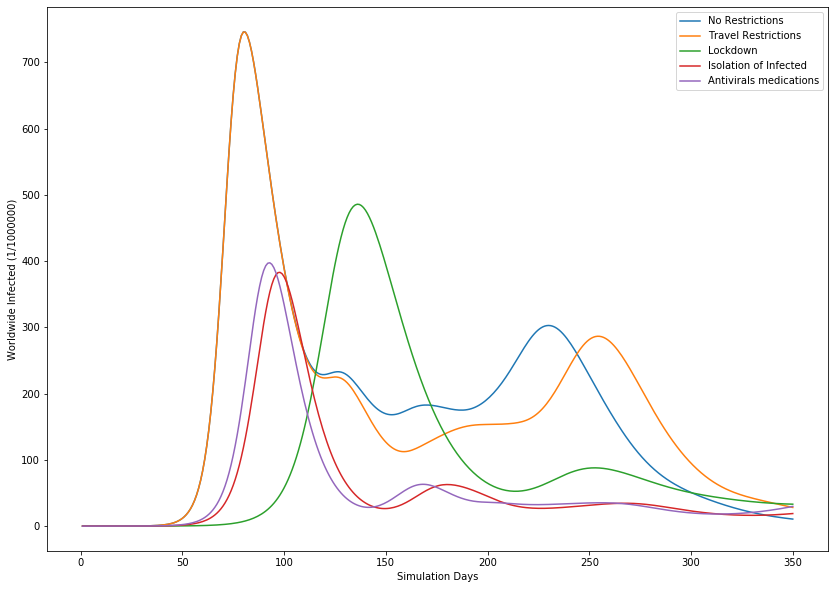

In [27]:
# World total Infected (1/1000000)
print("World")
plt.figure(figsize=(14,10))
plt.plot(list(range(1, T+1)), [np.array([I_lists[c][d] for c in countries]).sum()/1000000 for d in range(T)], label="No Restrictions")
plt.plot(list(range(1, T+1)), [np.array([I_lists_tr[c][d] for c in countries]).sum()/1000000 for d in range(T)], label="Travel Restrictions")
plt.plot(list(range(1, T+1)), [np.array([I_lists_lock[c][d] for c in countries]).sum()/1000000 for d in range(T)], label="Lockdown")
plt.plot(list(range(1, T+1)), [np.array([I_lists_iso[c][d] for c in countries]).sum()/1000000 for d in range(T)], label="Isolation of Infected")
plt.plot(list(range(1, T+1)), [np.array([I_lists_antiv[c][d] for c in countries]).sum()/1000000 for d in range(T)], label="Antivirals medications")
plt.xlabel('Simulation Days')
plt.ylabel('Worldwide Infected (1/1000000)')
plt.savefig(open("world-measures.png", 'wb'))
plt.legend()
plt.show()

In [28]:
# Show how isolation restrictions delayed the peak for each country
countries_peak_day_antiv = {c: I_lists_antiv[c].index(max(I_lists_antiv[c])) for c in countries}
countries_peak_delay_antiv = {k: countries_peak_day_antiv[k]-v for k, v in countries_peak_day.items()}

{k: v for k, v in sorted(countries_peak_delay_antiv.items(), key=lambda item: item[1])}

{'Nepal': -231,
 'Vietnam': -173,
 'Macau': -36,
 'China': 12,
 'South Korea': 13,
 'Israel': 28,
 'United States': 37,
 'Lebanon': 37,
 'Spain': 38,
 'Sweden': 42,
 'Iraq': 42,
 'Bahrain': 46,
 'Canada': 52,
 'Egypt': 52,
 'Iran': 64,
 'Germany': 65,
 'Kuwait': 65,
 'United Kingdom': 67,
 'Japan': 69,
 'Italy': 70,
 'Finland': 74,
 'Belgium': 85,
 'Russia': 86,
 'Afghanistan': 86,
 'Philippines': 91,
 'Australia': 96,
 'Cambodia': 101,
 'Oman': 102,
 'Thailand': 104,
 'Singapore': 108,
 'Sri Lanka': 111,
 'United Arab Emirates': 116,
 'India': 118,
 'Taiwan': 120,
 'France': 129,
 'Malaysia': 130,
 'Hong Kong': 147}

## Scenario 1
Travel Restrictions and Lockdown

In [29]:
# Simulation with travel restrictions and lockdown
S_lists_s1 = {}
I_lists_s1 = {}
R_lists_s1 = {}

# Initialise lists values
for c in countries:
    S_lists_s1[c] = [ country_populations[c] ]
    I_lists_s1[c] = [ confirmed.loc[c, confirmed.columns[0]] ]
    R_lists_s1[c] = [ deaths.loc[c, deaths.columns[0]] ]
    
# Percentage of air traffic retained
air_traffic_perc = 0.1
# Percentage of people still normally circulating
isolation_perc = 0.6
# Gamma increase caused by medication
gamma_increase = 0.05
# Days with confirmed cases after which apply travel restrictions
days_with_cases = 10

# Carry out simulation
for t in range(1, T):
    for c in countries:
        # Get people coming into the country for each compartment
        S_in_t = 0
        I_in_t = 0
        R_in_t = 0
        for n in g.nodes():
            if g.get_edge_data(n, c) is not None:
                if t >= days_with_cases and I_lists_s1[c][-days_with_cases] > 1:
                    n_in_route = g.get_edge_data(n, c)['weight'] * air_traffic_perc
                else: 
                    n_in_route = g.get_edge_data(n, c)['weight']
                n_total_pop = S_lists_s1[n][t-1] + I_lists_s1[n][t-1] + R_lists_s1[n][t-1]
                n_in_population = n_in_route * np.log10(n_total_pop)
                S_in_t += (S_lists_s1[n][t-1] / n_total_pop) * n_in_population
                I_in_t += (I_lists_s1[n][t-1] / n_total_pop) * n_in_population
                R_in_t += (R_lists_s1[n][t-1] / n_total_pop) * n_in_population
        # Get people going out of the country for each compartment
        current_population = S_lists_s1[c][t-1] + I_lists_s1[c][t-1] + R_lists_s1[c][t-1]
        current_S = S_lists_s1[c][t-1]
        if t >= days_with_cases and I_lists_s1[c][-days_with_cases] > 1:
            out_population = air_traffic_perc * out_routes[c] * np.log10(current_population)
            current_S *= isolation_perc
        else:
            out_population = out_routes[c] * np.log10(current_population)
        S_out_t = (S_lists_s1[c][t-1] / current_population) * out_population
        I_out_t = (I_lists_s1[c][t-1] / current_population) * out_population
        R_out_t = (R_lists_s1[c][t-1] / current_population) * out_population

        S_t = S_lists_s1[c][t-1] - ((current_S / S_lists_s1[c][0]) * (country_betas[c]*I_lists_s1[c][t-1]))
        S_lists_s1[c].append(S_t - S_out_t + S_in_t)
        
        I_t = I_lists_s1[c][t-1] + ((current_S / S_lists_s1[c][0]) * (country_betas[c]*I_lists_s1[c][t-1])) - (I_lists_s1[c][t-1] * country_gammas[c])
        I_lists_s1[c].append(I_t - I_out_t + I_in_t)
        
        R_t = R_lists_s1[c][t-1] + (I_lists_s1[c][t-1] * country_gammas[c])
        R_lists_s1[c].append(R_t - R_out_t + R_in_t)
        
      

World


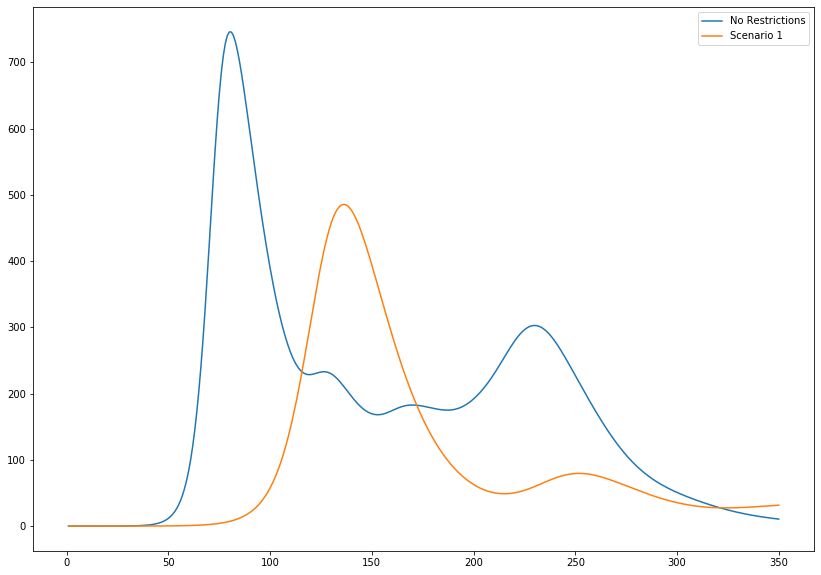

In [30]:
# World total Infected (1/1000000)
print("World")
plt.figure(figsize=(14,10))
plt.plot(list(range(1, T+1)), [np.array([I_lists[c][d] for c in countries]).sum()/1000000 for d in range(T)], label="No Restrictions")
plt.plot(list(range(1, T+1)), [np.array([I_lists_s1[c][d] for c in countries]).sum()/1000000 for d in range(T)], label="Scenario 1")
plt.legend()
plt.show()

In [31]:
# Show how isolation restrictions delayed the peak for each country
countries_peak_day_s1 = {c: I_lists_s1[c].index(max(I_lists_s1[c])) for c in countries}
countries_peak_delay_s1 = {k: countries_peak_day_s1[k]-v for k, v in countries_peak_day.items()}

{k: v for k, v in sorted(countries_peak_delay_s1.items(), key=lambda item: item[1])}

{'Nepal': -150,
 'Vietnam': -119,
 'Macau': 20,
 'Iraq': 42,
 'Bahrain': 46,
 'Egypt': 52,
 'China': 56,
 'South Korea': 60,
 'Kuwait': 65,
 'Lebanon': 73,
 'Afghanistan': 86,
 'Philippines': 91,
 'Israel': 92,
 'Thailand': 104,
 'Singapore': 108,
 'Sri Lanka': 111,
 'United Arab Emirates': 116,
 'Spain': 118,
 'India': 118,
 'Oman': 120,
 'United States': 122,
 'Sweden': 126,
 'Finland': 127,
 'Belgium': 127,
 'Malaysia': 130,
 'France': 132,
 'Germany': 145,
 'Hong Kong': 149,
 'Taiwan': 152,
 'Australia': 153,
 'Cambodia': 158,
 'Italy': 163,
 'United Kingdom': 166,
 'Russia': 174,
 'Canada': 180,
 'Iran': 180,
 'Japan': 185}

## Scenario 2
Travel Restrictions, Isolation, and Antiviral Medication

In [32]:
# Simulation with travel restrictions 
S_lists_s2 = {}
I_lists_s2 = {}
R_lists_s2 = {}

# Initialise lists values
for c in countries:
    S_lists_s2[c] = [ country_populations[c] ]
    I_lists_s2[c] = [ confirmed.loc[c, confirmed.columns[0]] ]
    R_lists_s2[c] = [ deaths.loc[c, deaths.columns[0]] ]
    
# Percentage of air traffic retained
air_traffic_perc = 0.1
# Percentage of infected not isolated
isolation_perc = 0.95
# Days with confirmed cases after which apply travel restrictions
days_with_cases = 10

# Carry out simulation
for t in range(1, T):
    for c in countries:
        # Get people coming into the country for each compartment
        S_in_t = 0
        I_in_t = 0
        R_in_t = 0
        for n in g.nodes():
            if g.get_edge_data(n, c) is not None:
                if t >= days_with_cases and I_lists_s2[c][-days_with_cases] > 1:
                    n_in_route = g.get_edge_data(n, c)['weight'] * air_traffic_perc
                else: 
                    n_in_route = g.get_edge_data(n, c)['weight']
                n_total_pop = S_lists_s2[n][t-1] + I_lists_s2[n][t-1] + R_lists_s2[n][t-1]
                n_in_population = n_in_route * np.log10(n_total_pop)
                S_in_t += (S_lists_s2[n][t-1] / n_total_pop) * n_in_population
                I_in_t += (I_lists_s2[n][t-1] / n_total_pop) * n_in_population
                R_in_t += (R_lists_s2[n][t-1] / n_total_pop) * n_in_population
        # Get people going out of the country for each compartment
        current_population = S_lists_s2[c][t-1] + I_lists_s2[c][t-1] + R_lists_s2[c][t-1]
        current_infected = I_lists_iso[c][t-1]
        current_gamma = country_gammas[c]
        if t >= days_with_cases and I_lists_s2[c][-days_with_cases] > 1:
            out_population = air_traffic_perc * out_routes[c] * np.log10(current_population)
            current_infected *= isolation_perc 
            current_gamma += gamma_increase
        else:
            out_population = out_routes[c] * np.log10(current_population)
        S_out_t = (S_lists_s2[c][t-1] / current_population) * out_population
        I_out_t = (I_lists_s2[c][t-1] / current_population) * out_population
        R_out_t = (R_lists_s2[c][t-1] / current_population) * out_population

        S_t = S_lists_s2[c][t-1] - ((S_lists_s2[c][t-1] / S_lists_s2[c][0]) * (country_betas[c]*current_infected))
        S_lists_s2[c].append(S_t - S_out_t + S_in_t)
        
        I_t = current_infected + ((S_lists_s2[c][t-1] / S_lists_s2[c][0]) * (country_betas[c]*current_infected)) - (current_infected * current_gamma)
        I_lists_s2[c].append(I_t - I_out_t + I_in_t)
        
        R_t = R_lists_s2[c][t-1] + (current_infected * current_gamma)
        R_lists_s2[c].append(R_t - R_out_t + R_in_t)
        

World


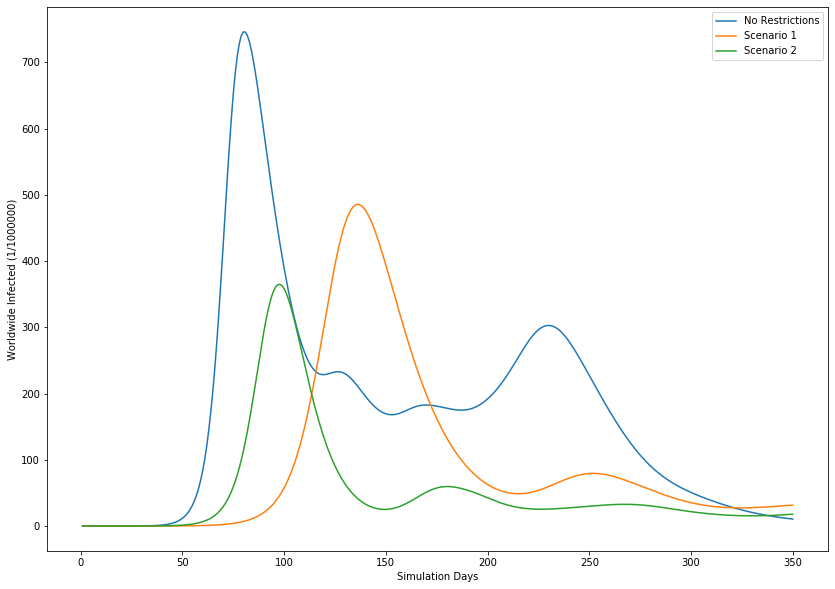

In [33]:
# World total Infected (1/1000000)
print("World")
plt.figure(figsize=(14,10))
plt.plot(list(range(1, T+1)), [np.array([I_lists[c][d] for c in countries]).sum()/1000000 for d in range(T)], label="No Restrictions")
plt.plot(list(range(1, T+1)), [np.array([I_lists_s1[c][d] for c in countries]).sum()/1000000 for d in range(T)], label="Scenario 1")
plt.plot(list(range(1, T+1)), [np.array([I_lists_s2[c][d] for c in countries]).sum()/1000000 for d in range(T)], label="Scenario 2")
plt.legend()
plt.xlabel('Simulation Days')
plt.ylabel('Worldwide Infected (1/1000000)')
plt.savefig(open('world-scenarios.png', 'wb'))
plt.show()

In [34]:
# Show how isolation restrictions delayed the peak for each country
countries_peak_day_s2 = {c: I_lists_s2[c].index(max(I_lists_s2[c])) for c in countries}
countries_peak_delay_s2 = {k: countries_peak_day_s2[k]-v for k, v in countries_peak_day.items()}

{k: v for k, v in sorted(countries_peak_delay_s2.items(), key=lambda item: item[1])}

{'Nepal': -222,
 'Vietnam': -165,
 'Macau': -27,
 'China': 17,
 'South Korea': 18,
 'Lebanon': 27,
 'Israel': 30,
 'Spain': 30,
 'Iraq': 42,
 'Bahrain': 46,
 'United States': 47,
 'Sweden': 51,
 'Egypt': 52,
 'Canada': 63,
 'Kuwait': 65,
 'Germany': 71,
 'Finland': 76,
 'Iran': 77,
 'United Kingdom': 81,
 'Japan': 82,
 'Italy': 84,
 'Oman': 86,
 'Afghanistan': 86,
 'Philippines': 91,
 'Belgium': 94,
 'Russia': 102,
 'Thailand': 104,
 'Singapore': 108,
 'Sri Lanka': 111,
 'Australia': 115,
 'United Arab Emirates': 116,
 'India': 118,
 'Cambodia': 119,
 'Malaysia': 130,
 'France': 132,
 'Taiwan': 142,
 'Hong Kong': 149}

In [137]:
# Copy of Model for Tasks
gM = g.copy()
# Random Erdos Graphs
g1 = nx.erdos_renyi_graph(len(g), 0.53, directed=True)
g2 = nx.erdos_renyi_graph(len(g), 0.53, directed=True)
g3 = nx.erdos_renyi_graph(len(g), 0.53, directed=True)

## Task 1

In [214]:
# Graph Values: nodes, edges, av_path_len, av_cluster_coef
def graphValues(graphs, graphTitle, verbose=True):
    allData = []
    # Get all graphs data
    for g in graphs:
        graph_values = {}
        graph_values['nodes'] = len(g)
        graph_values['edges'] = g.number_of_edges()
        graph_values['av_path_length'] = nx.average_shortest_path_length(g)
        graph_values['av_cluster_coef'] = nx.average_clustering(g)
        allData.append(graph_values)

    # Get averages of all graphs
    averages = {'av_nodes': 0, 'av_edges': 0, 'av_path_length': 0, 'av_cluster_coef':0}
    for el in range(len(allData)):
        averages['av_nodes'] += allData[el].get('nodes')
        averages['av_edges'] += allData[el].get('edges')
        averages['av_path_length'] += allData[el].get('av_path_length')
        averages['av_cluster_coef'] += allData[el].get('av_cluster_coef')
    for key in averages:
        averages[key] = averages[key]/len(allData)

    # Print all Processed Data    
    if (verbose):
        print(graphTitle)
        for val in averages:
            print(val, ':', averages[val])
        
    return averages


# Compare averages of tw graphs
def compare_averages(graph1, graph2, verbose=True):
    # List for difference data
    difference = {'nodeDiff': 0, 'edgeDiff': 0, 'pathDiff': 0, 'clusterDiff': 0}
    # Keys of lists/graphs
    diffKeys = list(difference.keys())
    graphKeys = list(graph1.keys())
    
    # Loop through list, calculating difference b/w graph1 & 2
    for i in range(len(difference)):
        difference[diffKeys[i]] = abs(graph1.get(graphKeys[i]) - graph2.get(graphKeys[i]))
        
    if verbose:
        # Print result
        print('\nDifference b/w graphs')
        for val in difference:
            print(val, ':', difference[val])
    return difference



# Graph Values
graphAv_model = graphValues([gM], 'Model Graph')
graphAv_rand = graphValues([g1,g2,g3], 'Average_Random')

# Differences in graphs
graphDiff = compare_averages(graphAv_model, graphAv_rand)

Model Graph
av_nodes : 37.0
av_edges : 354.0
av_path_length : 1.834834834834835
av_cluster_coef : 0.3802877284769844
Average_Random
av_nodes : 37.0
av_edges : 691.6666666666666
av_path_length : 1.4807307307307305
av_cluster_coef : 0.5191295385210676

Difference b/w graphs
nodeDiff : 0.0
edgeDiff : 337.66666666666663
pathDiff : 0.3541041041041044
clusterDiff : 0.1388418100440832


## Task 2 - Part 1 
Caculate size of Giant Component of Model and average size of Random Graphs

In [215]:
import random

# Size of Giant component
def size_giant_component(g, verbose=True):
    giantComp = max(nx.strongly_connected_components(g), key=len)    # Get giant component
    giantGraph = g.subgraph(giantComp)    # Make component a subgraph
    sizeGc = giantGraph.size()    # Get size of giant component

    if verbose:
        print("gc_model:", sizeGc)
    return sizeGc

# Av size giant component for mult graphs
def average_giant_rand(graphs, verbose=True):
    giantSizes = []
    # Calculate size of gc of each graph, append to list
    for g in graphs:
        giantSizes.append(size_giant_component(g, False))
    # Calculate average
    average = 0
    for val in giantSizes:
        average += val
    average /= len(giantSizes)
    
    if verbose:
        print("gc_av_rand:", average)
    return average


# GC Size of Model
gc_model = size_giant_component(g_m)

# GC Size of rand
gc_av_rand = average_giant_rand([g1,g2,g3])

# Diff b/w Model & Av
gc_diff = abs(gc_model-gc_av_rand)
print("Diff_model_rand:", gc_diff)


gc_model: 354
gc_av_rand: 691.6666666666666
Diff_model_rand: 337.66666666666663


## Task 2 - Part 2
Remove nodes from graphs at given threshold, calculate gc at each step.
For both Model and Average of Random Graphs.

In [146]:
# NODE REMOVAL & Test Giant
def remove_thres_giant(g, thres_percent, verbose=True):
    g = g.copy()       # Copy graph to not modify main
    g_gc_size = []
    
    # Get list & num of nodes in graph
    list_of_nodes = g.nodes()
    number_of_nodes = g.number_of_nodes()
    # set threshold percent to graph
    threshold = int(number_of_nodes / thres_percent)
    
    # Loop until all nodes are removed (currently checks if next iteration would break)
    while (number_of_nodes - threshold > 0):
        # Get rand sample to remove based on threshold
        threshold_sample = random.sample(list_of_nodes, threshold)
        #remove rand sample from graph
        g.remove_nodes_from(threshold_sample)
        # get size of giant comp
        size_gc = size_giant_component(g, False)
        g_gc_size.append(size_gc)
        # Update number of nodes left in graph
        number_of_nodes = g.number_of_nodes()
        # Print Results
        if verbose:
            print("graph:", g.number_of_nodes(), ", gc_size:", size_gc)
    return g_gc_size

# Get average gc size w/ node removal @ threshold
def average_giant_remove_tres(graphs, thres_percent, verbose=True):
    all_giant_Av = []
    
    # Loop throug all graphs, getting the gc_change over thres
    for g in graphs:
        all_giant_Av.append(remove_thres_giant(g, thres_percent, False))
    
    # Loop through all gc_change, adding val
    giant_Av = [0 for i in range(len(all_giant_Av[0]))]
    for i in range(len(all_giant_Av)):
        for j in range(len(all_giant_Av[i])):
            giant_Av[j] += all_giant_Av[i][j]

            # Get average for all val
    for i in range(len(giant_Av)):
        giant_Av[i] /= len(graphs)

    # Print results
    if verbose:
        print('all_giant:', all_giant_Av)
        print('giant_av:', giant_Av)
    return giant_Av


# Giant_comp change to Model
gM_remove_thres = remove_thres_giant(gM, 10, False)
rand_av_remove = average_giant_remove_tres([g1, g2, g3], 10, False)

print("gM_change:", gM_remove_thres)
print("rand_change:", rand_av_remove)


gM_change: [278, 219, 176, 121, 97, 71, 38, 14, 5, 0, 0, 0]
rand_change: [582.6666666666666, 485.3333333333333, 392.3333333333333, 314.0, 241.0, 177.33333333333334, 121.0, 79.0, 43.666666666666664, 21.333333333333332, 5.333333333333333, 0.0]


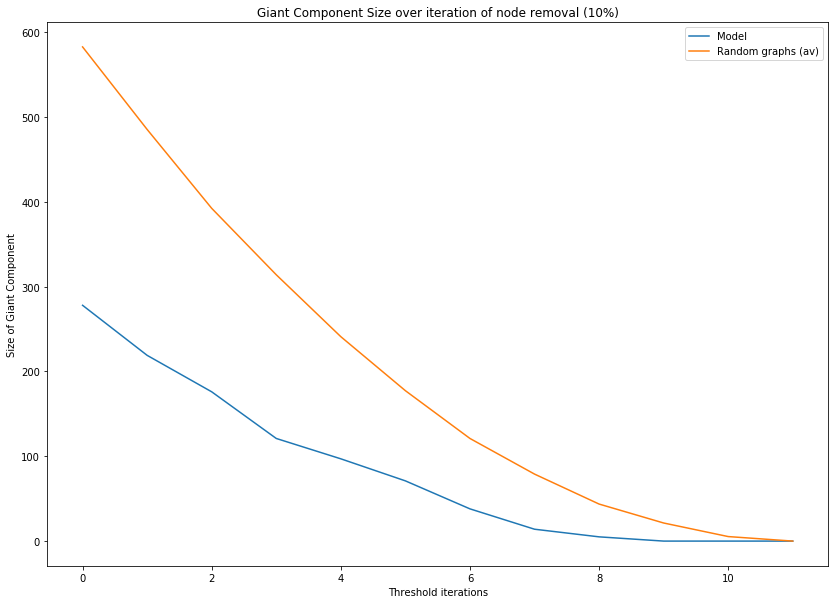

In [147]:
# Plot GC change b/w Model & Rand
plt.figure(figsize=(14,10))
plt.plot(gM_remove_thres, label='Model')
plt.plot(rand_av_remove, label='Random graphs (av)')
plt.legend()
plt.title('Giant Component Size over iteration of node removal (10%)')
plt.xlabel('Threshold iterations')
plt.ylabel('Size of Giant Component')
plt.show()

## Task 3 - Part 1
Get pagerank of Model

In [216]:
# Copy Model
gM = g.copy()

def model_pagerank(gM, verbose=False):
    # Get pagerank of Model
    g_pagerank = nx.pagerank(gM)

    if verbose:
        # Get x-y for chart
        countries = list(g_pagerank.keys())
        count_rank = list(g_pagerank.values())

        # Plot chart for Model
        plt.figure(figsize=(14,10))
        plt.plot(countries, count_rank)
        plt.xticks(x, rotation='vertical')
        plt.margins(0.05)
        plt.title('Pagerank of Model')
        plt.xlabel('Countries in Model')
        plt.ylabel('Pagerank')
        plt.show
    return g_pagerank

# Calculate Model (Pass 'True' arg to display results)
gM_pagerank = model_pagerank(gM)


In [196]:
# Plot histogram for model
def model_pagerank_hist(verbose=False):
    if verbose:
        plt.hist(count_rank, bins=10)
        plt.show

# Pass 'True' arg to display results
model_pagerank_hist()


## Task 3 - Part 2
Get average pagerank of Random Graphs

In [199]:
# Get average pagerank for array of graphs
def av_pagerank(graphs):
    graphs_pagerank = []
    # Loop through all graphs, store pagerank seperately
    for g in graphs:
        graphs_pagerank.append(nx.pagerank(g))
    # Create empty index dict for averages
    av_pagerank = dict.fromkeys(range(len(graphs_pagerank[0])),0)
    # Add all pagerank to dict
    for i in range(len(graphs_pagerank)):
        for j in range(len(graphs_pagerank[0])):
            av_pagerank[j] += graphs_pagerank[i][j] 
    # Get pagerank average
    for i in range(len(av_pagerank)):
        av_pagerank[i] /= len(graphs_pagerank)
    return av_pagerank


# Get average pageranks and display restults
def rand_pagerank(graphs, verbose=False):
    rand_pagerank = av_pagerank(graphs)
    
    if verbose:
        # Get y for chart
        count_rank = list(rand_pagerank.values())

        # Plot chart for Model
        plt.figure(figsize=(14,10))
        plt.plot(count_rank)
        plt.margins(0.05)
        plt.title('Average Pagerank of Random Graphs')
        plt.xlabel('Nodes in Rand Graph')
        plt.ylabel('Pagerank')
        plt.show
    return rand_pagerank
        

# Calculate Average pagerank (pass 'True' arg to display resutls)    
rand_av_pagerank = rand_pagerank([g1,g2,g3])


## Task 3 - Part 3
Compare pagerank b/w Model and RandomGraphs

<function matplotlib.pyplot.show(*args, **kw)>

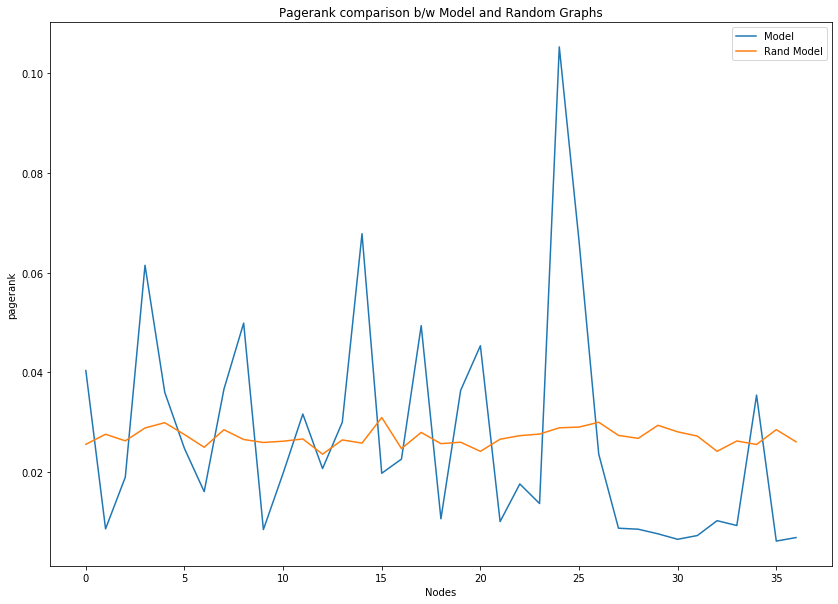

In [203]:
# Compare pagerank of Model and Rand
# model pagerank
model_rank = list(gM_pagerank.values())
rand_rank = list(rand_av_pagerank.values())

# Graph
plt.figure(figsize=(14,10))
plt.plot(model_rank, label='Model')
plt.plot(rand_rank, label='Rand Model')
plt.legend()
plt.title('Pagerank comparison b/w Model and Random Graphs')
plt.xlabel('Nodes')
plt.ylabel('pagerank')
plt.show

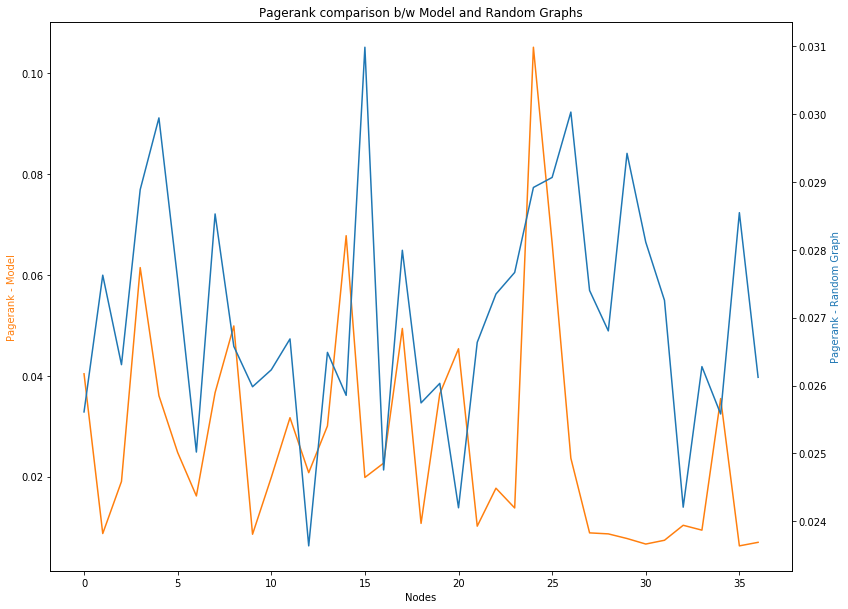

In [240]:
# Pagerank comparison on two axis
fig, ax1 = plt.subplots()
ax1.set_title('Pagerank comparison b/w Model and Random Graphs')

color = 'tab:orange'
ax1.set_xlabel('Nodes')
ax1.set_ylabel('Pagerank - Model', color=color)
ax1.plot(model_rank, color=color)
ax1.tick_params(axis='y',)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Pagerank - Random Graph', color=color)
ax2.plot(rand_rank, color=color)
ax2.tick_params(axis='y')

fig.tight_layout()
fig.set_figheight(10)
fig.set_figwidth(14)

plt.show()

## Task 4

In [37]:
degree_centrality = nx.algorithms.degree_centrality(g)
print({k: v for k, v in sorted(degree_centrality.items(), key=lambda item: item[1])})

{'Afghanistan': 0.1111111111111111, 'Iraq': 0.2222222222222222, 'Macau': 0.25, 'Cambodia': 0.25, 'Nepal': 0.25, 'Lebanon': 0.3611111111111111, 'Australia': 0.38888888888888884, 'Bahrain': 0.38888888888888884, 'Sweden': 0.41666666666666663, 'Oman': 0.41666666666666663, 'Vietnam': 0.4444444444444444, 'Sri Lanka': 0.4444444444444444, 'Kuwait': 0.4444444444444444, 'Israel': 0.4722222222222222, 'Philippines': 0.4722222222222222, 'Finland': 0.4722222222222222, 'Iran': 0.4722222222222222, 'Belgium': 0.4722222222222222, 'Spain': 0.4722222222222222, 'Taiwan': 0.5, 'Canada': 0.5, 'Egypt': 0.5277777777777778, 'United States': 0.611111111111111, 'Japan': 0.611111111111111, 'Malaysia': 0.611111111111111, 'Singapore': 0.6388888888888888, 'Hong Kong': 0.6388888888888888, 'Russia': 0.6666666666666666, 'Italy': 0.6944444444444444, 'South Korea': 0.7222222222222222, 'India': 0.75, 'United Kingdom': 0.7777777777777777, 'France': 0.7777777777777777, 'Germany': 0.8333333333333333, 'China': 0.83333333333333

In [38]:
def show_weighted_graph(networkx_graph, node_size, font_size, fig_size, node_colors, nodes_position):
    # Allocate the given fig_size in order to have space for each node
    plt.figure(num=None, figsize=fig_size, dpi=80)
    plt.axis('off')
    # You can change the different layouts depending on your graph
    # Extract the weights corresponding to each edge in the graph
    edges_weights  = nx.get_edge_attributes(networkx_graph,'weight')
    # Draw the nodes (you can change the color)
    nx.draw_networkx_nodes(networkx_graph, nodes_position, node_size=node_size,  
                         node_color = node_colors)
    # Draw only the edges
    nx.draw_networkx_edges(networkx_graph, nodes_position, 
                         edgelist=list(networkx_graph.edges), width=2)
    # Add the weights
    nx.draw_networkx_edge_labels(networkx_graph, nodes_position, 
                               edge_labels = edges_weights)
    # Add the labels of the nodes
    nx.draw_networkx_labels(networkx_graph, nodes_position, font_size=font_size, 
                          font_family='sans-serif')
    plt.axis('off')
    plt.show()

In [39]:
thresholds = [0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.275, 0.3]
cascades = {}
for threshold in thresholds:
    gg = g.copy()

    initial_config = {'South Korea': {'Infected': 0}, 'Israel': {'Infected': 0}, 'Philippines': {'Infected': 0}, 'United States': {'Infected': 0}, 'United Kingdom': {'Infected': 0}, 'Singapore': {'Infected': 0}, 'Sweden': {'Infected': 0}, 'Italy': {'Infected': 0}, 'France': {'Infected': 0}, 'Finland': {'Infected': 0}, 'Vietnam': {'Infected': 0}, 'Russia': {'Infected': 0}, 'Macau': {'Infected': 0}, 'Taiwan': {'Infected': 0}, 'Japan': {'Infected': 0}, 'Malaysia': {'Infected': 0}, 'Thailand': {'Infected': 0}, 'Germany': {'Infected': 0}, 'Australia': {'Infected': 0}, 'United Arab Emirates': {'Infected': 0}, 'Canada': {'Infected': 0}, 'Bahrain': {'Infected': 0}, 'Iran': {'Infected': 0}, 'Belgium': {'Infected': 0}, 'China': {'Infected': 0}, 'Spain': {'Infected': 0}, 'Hong Kong': {'Infected': 0}, 'Sri Lanka': {'Infected': 0}, 'Kuwait': {'Infected': 0}, 'Oman': {'Infected': 0}, 'Lebanon': {'Infected': 0}, 'Iraq': {'Infected': 0}, 'Egypt': {'Infected': 0}, 'Cambodia': {'Infected': 0}, 'India': {'Infected': 0}, 'Nepal': {'Infected': 0}, 'Afghanistan': {'Infected': 0}}
    initial_config['China'] = {'Infected': 1}
    nx.set_node_attributes(gg, initial_config)

    iterations = [nx.get_node_attributes(gg, "Infected")]
    n_iter = 10
    for i in range(n_iter):
        for node in gg.nodes():
            if gg.nodes[node]['Infected'] == 0:
                neighbors = list(gg.predecessors(node))
                infected_neighbors = 0
                for n in neighbors:
                    if node != n and nx.get_node_attributes(gg, "Infected")[n] == 1:
                        infected_neighbors += 1
                if infected_neighbors / len(neighbors) > threshold:
                    gg.nodes[node]['Infected'] = 1
        iterations.append(nx.get_node_attributes(gg, "Infected"))
        
    cascades[threshold] = iterations
    

Iteration 0


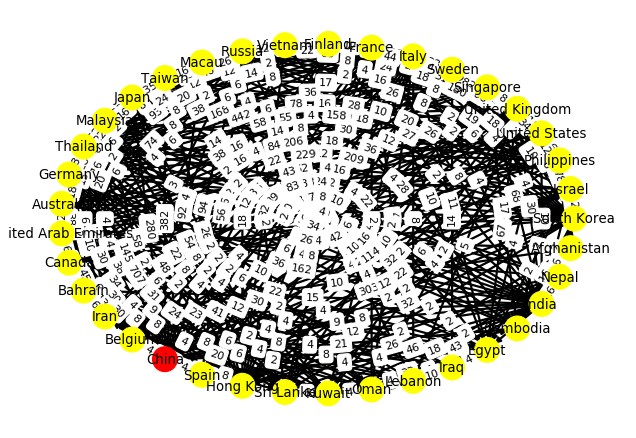

Iteration 1


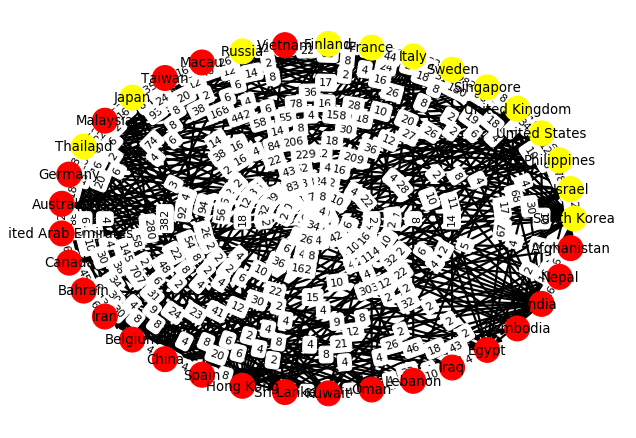

Iteration 2


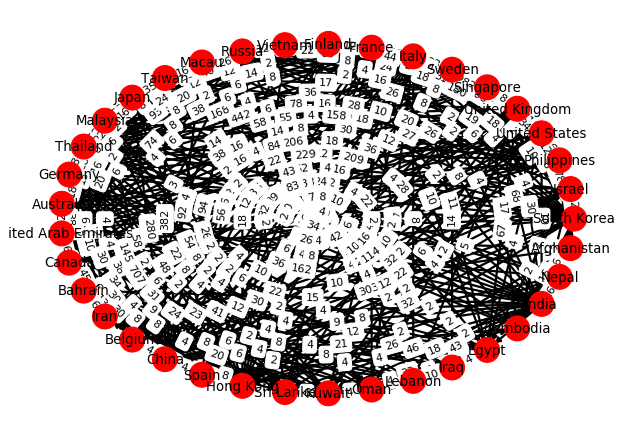

Iteration 3


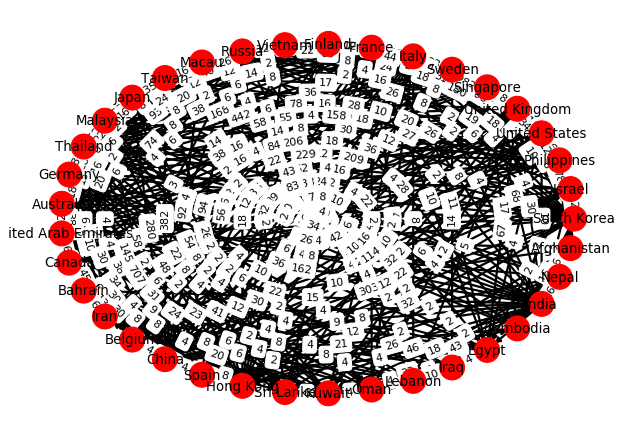

Iteration 4


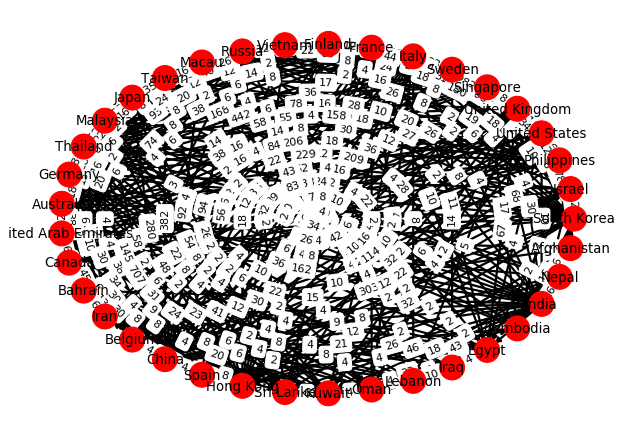

Iteration 5


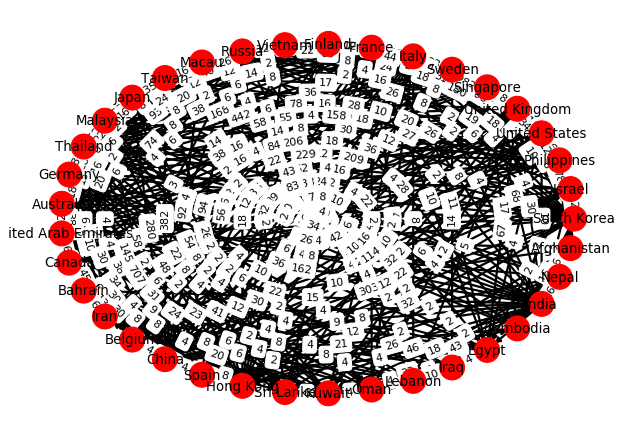

Iteration 6


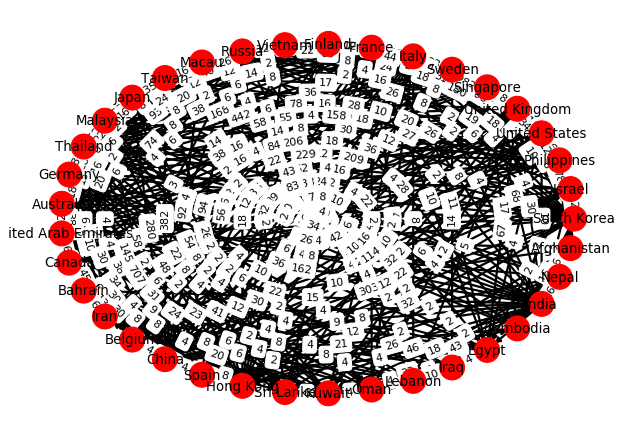

Iteration 7


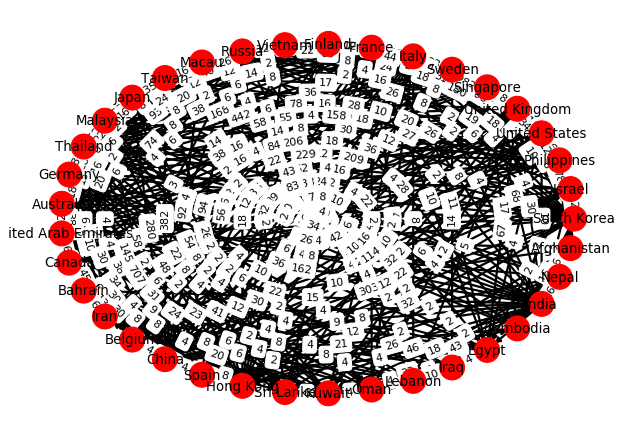

Iteration 8


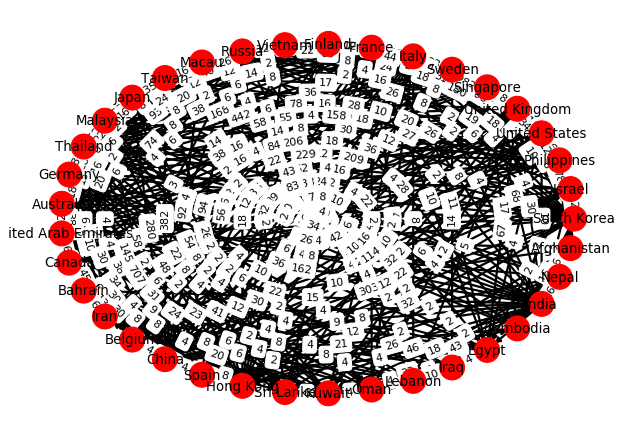

Iteration 9


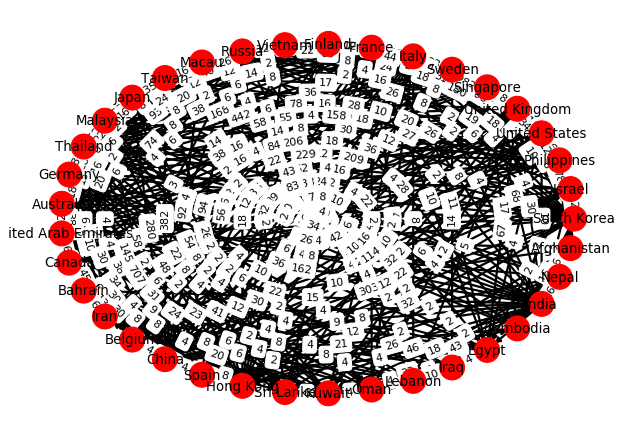

Iteration 10


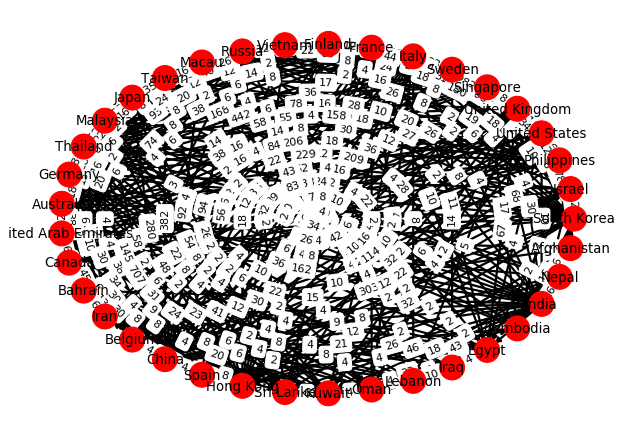

In [40]:
import time

# Compute the position of each vertex in order to display it nicely
nodes_position = nx.shell_layout(gg) 
iters = cascades[0.1]

for i in range(len(iters)):
    print("Iteration {}".format(i))
    colors = []
    for node_id, new_status in iters[i].items():
        # Node Infected
        if new_status == 1:
            colors.append('red')
        else:
            colors.append('yellow')
            
    show_weighted_graph(g, 500, 12, (10,7), colors, nodes_position)

In [41]:
sweden_x = []
for t in Sweden_thresholds:
    found = False
    for i in range(len(Sweden_thresholds[t])):
        if sum(list(Sweden_thresholds[t][i].values())) == len(Sweden_thresholds[t][i]):
            sweden_x.append(i)
            found = True
            break
    if not found:
        sweden_x.append(None)

sweden_x

NameError: name 'Sweden_thresholds' is not defined

In [ ]:
china_x = []
for t in China_thresholds:
    found = False
    for i in range(len(China_thresholds[t])):
        if sum(list(China_thresholds[t][i].values())) == len(China_thresholds[t][i]):
            china_x.append(i)
            found = True
            break
    if not found:
        china_x.append(None)

china_x

In [ ]:

China_thresholds = cascades.copy()

In [ ]:
plt.plot(thresholds, china_x)
plt.xlabel('Threshold value')
plt.ylabel('Iterations taken infect network')
plt.savefig(open("china-cascade.png", "wb"))

In [ ]:
plt.plot(thresholds, sweden_x)
plt.xlabel('Threshold value')
plt.ylabel('Iterations taken infect network')
plt.savefig(open("sweden-cascade.png", "wb"))